# Exploration Data
This notebook shows data exploration to build a model (or several) in order to classify housing assistance requests thanks to the given datasets.

This is a multi-class classification task

The metric to optimize and the datasets description are explained in DS_technical_test_tutorial.ipynb Jupyter Notebook.

## import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import datetime
import re
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

# for geo lat/lon
from geopy.geocoders import Nominatim

## Definition

In [538]:
PATH_TO_REG = "data/geofrance/regions.csv"
PATH_TO_DEP = "data/geofrance/departments.csv"
PATH_TO_CIT = "data/geofrance/cities.csv"

# EXPORT
PATH_REQ_TRAIN_CLEAN = 'data/requests_train_clean.csv'
PATH_REQ_TEST_CLEAN = 'data/requests_test_clean.csv'

PATH_IND_TRAIN_CLEAN = 'data/individuals_train_clean.csv'
PATH_IND_TEST_CLEAN = 'data/individuals_test_clean.csv'

## Useful functions

In [3]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


def display_missing(df):
    '''
    Function to display missing values into dataframe.
    Creates a barplots figure and outputs values.

    - input : 
        df : dataframe : data to check
    - output : 
        df_missing : dataframe : table of missing values
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing


def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=7, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
def plot_cont(X,Y,data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = data[X].value_counts()
    ty = data[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    cont

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    # plot
    fig = plt.figure(figsize = (5,11.75))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Load raw data

In [4]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

request_id animal_presence     answer_creation_date  \
0  130667d2964de43c511d0ead7ac66b33               f      2019-02-11 22:30:00   
1  b1cd62fcf24eebb0f685d5eaf55317a8               f      2019-02-12 09:00:00   
2  12cc0a18890bd4959fe42df3ae58838e               f      2019-02-01 21:00:00   
3  ae2d5b4dc181d29e430132f145da1556               f  2019-02-25 15:12:05.037   
4  d13a17ce36c832514fda2464e11c4a9f               f  2019-02-20 09:59:20.603   

   child_situation child_to_come  district  granted_number_of_nights  \
0               -1           NaN        85                         1   
1               -1           NaN        85                         1   
2               -1           NaN        59                         1   
3               -1           NaN        50                         2   
4               -1           NaN        93                         2   

   group_composition_id  group_composition_label      group_creation_date  \
0                    10                man alone  2018-05-03 12:10:40.416   
1                    10                man alone  2019-03-07 12:11:08.545   
2                    80  isolated child/underage  2019-03-13 12:54:15.887   
3                    20              woman alone  2018-10-09 14:37:29.773   
4                    60    group with child(ren)  2018-10-02 10:47:36.931   

   ...             housing_situation_label long_term_housing_request  \
0  ...                               other                       NaN   
1  ...                               other                       NaN   
2  ...                              street                       NaN   
3  ...                                 NaN                       NaN   
4  ...  hotel paid by the emergency centre                       NaN   

  number_of_underage     request_backoffice_creator_id  \
0                 -1  eecd6110b7e9157e6423428b22a28159   
1                 -1  eecd6110b7e9157e6423428b22a28159   
2                 -1  686d962128c7622aa79ed91da13f5c77   
3                 -1  ec29519464c381a6630f4e480a0c000e   
4                 -1  c8b5cc926b1d7212224a08baa9619518   

     request_creation_date requester_type               social_situation_id  \
0      2019-02-11 22:30:00    third party  9a84febc47fedaf2c81d7c755e9edc85   
1      2019-02-12 09:00:00           user  11f64f0547e855c5c59329b9edc63063   
2      2019-02-01 21:00:00           user  898ab2883f410f4c6fb042ef16329fbb   
3  2019-02-25 15:12:05.037           user  3998c8e890ddc980527dd1af45dfa672   
4  2019-02-20 09:59:20.603           user  74a10d96eae43586bc3c46e89719b821   

  town victim_of_violence victim_of_violence_type  
0  NaN                  f                     NaN  
1  NaN                  f                     NaN  
2  NaN                  f                     NaN  
3  NaN                  t                   woman  
4  NaN                  f                     NaN  

[5 rows x 24 columns]

In [5]:
requests_train.shape

(238191, 24)

In [6]:
requests_test.shape

(59548, 24)

In [7]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

request_id                     individual_id  \
0  130667d2964de43c511d0ead7ac66b33  b24a8cfaaf3663bac45ca3bcd24f0b36   
1  b1cd62fcf24eebb0f685d5eaf55317a8  eef783d1bda82661a751c12c34aff8c2   
2  12cc0a18890bd4959fe42df3ae58838e  927b6fa58d6be263c411332835b11fec   
3  ae2d5b4dc181d29e430132f145da1556  94181d5cf4a56cc84d12677df84e2e03   
4  d13a17ce36c832514fda2464e11c4a9f  e79d2e3f9ace50049f1796c098008c13   

   housing_situation_2_id              housing_situation_2_label  birth_month  \
0                      20                          on the street            5   
1                      20                          on the street            5   
2                      20                          on the street            1   
3                      20                          on the street            7   
4                      35  hotel paid by the emergency structure            9   

   birth_year childcare_center_supervision disabled_worker_certification  \
0        1977                          NaN                           NaN   
1        1980                          NaN                           NaN   
2        2003                          NaN                           NaN   
3        1986                          NaN                           NaN   
4        1980                          NaN                           NaN   

   gender individual_creation_date  individual_role  individual_role_2_id  \
0    male               2018-01-29  isolated person                    30   
1    male               2019-03-07              NaN                    30   
2    male               2019-03-13              NaN                    10   
3  female               2018-10-09              NaN                    30   
4  female               2017-06-22   husband/spouse                     1   

   individual_role_2_label  marital_status_id marital_status_label pregnancy  
0           isolated adult                 10        single person         f  
1           isolated adult                 -1                  NaN         f  
2  isolated underage/child                 -1                  NaN         f  
3           isolated adult                 -1                  NaN         f  
4                  partner                 -1                  NaN         f

In [8]:
individuals_train.shape

(384133, 16)

In [9]:
individuals_test.shape

(95641, 16)

## Target : classes to predict

In [10]:
requests_train["granted_number_of_nights"].value_counts(dropna=False)

0    116542
1     81723
2     37340
3      2586
Name: granted_number_of_nights, dtype: int64

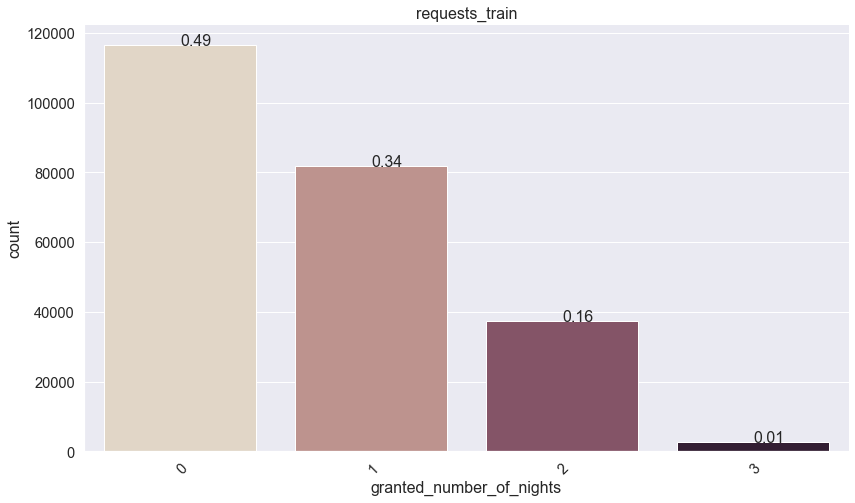

In [11]:
plot_hist_cat(x="granted_number_of_nights", data=requests_train, 
              title="requests_train")

In [12]:
requests_test["granted_number_of_nights"].value_counts(dropna=False)

0    29201
1    20478
2     9245
3      624
Name: granted_number_of_nights, dtype: int64

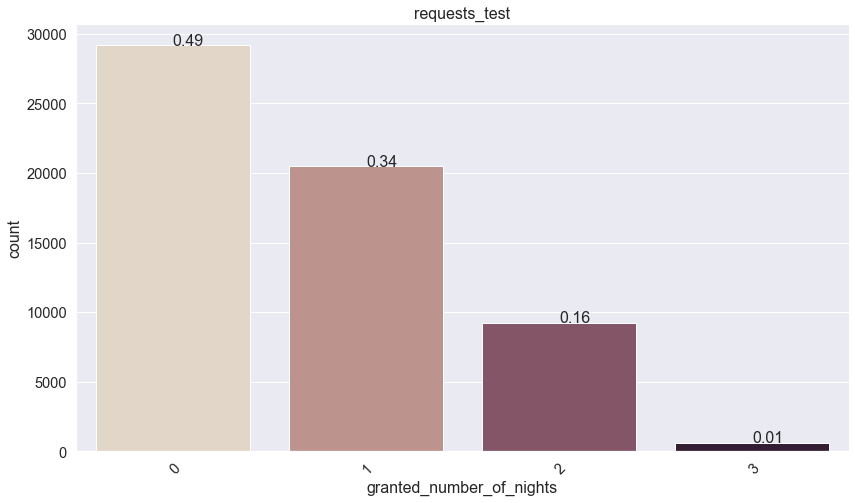

In [13]:
plot_hist_cat(x="granted_number_of_nights", data=requests_test, 
              title="requests_test")

OK => Same proportion in train and test data.

## Missing data

### requests_train

nb_missing      ratio
request_id                              0   0.000000
social_situation_id                     0   0.000000
requester_type                          0   0.000000
request_creation_date                   0   0.000000
request_backoffice_creator_id           0   0.000000
number_of_underage                      0   0.000000
housing_situation_id                    0   0.000000
group_type                              0   0.000000
victim_of_violence                      0   0.000000
group_id                                0   0.000000
group_main_requester_id                 0   0.000000
group_composition_label                 0   0.000000
group_composition_id                    0   0.000000
granted_number_of_nights                0   0.000000
district                                0   0.000000
child_situation                         0   0.000000
answer_creation_date                    0   0.000000
animal_presence                         0   0.000000
group_creation_date                     0   0.000000
housing_situation_label             16748   7.031332
child_to_come                      145947  61.273096
town                               159959  67.155770
long_term_housing_request          165556  69.505565
victim_of_violence_type            234175  98.313958

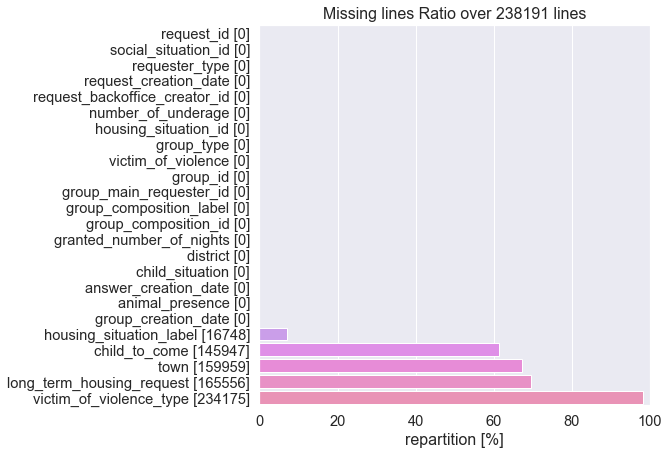

In [14]:
display_missing(requests_train)

In [15]:
requests_train.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                   other   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                   other   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   

                                                              2  \
request_id                     12cc0a18890bd4959fe42df3ae58838e   
animal_presence                                               f   
answer_creation_date                        2019-02-01 21:00:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     59   
granted_number_of_nights                                      1   
group_composition_id                                         80   
group_composition_label                 isolated child/underage   
group_creation_date                     

### requests_test

nb_missing      ratio
request_id                              0   0.000000
social_situation_id                     0   0.000000
requester_type                          0   0.000000
request_creation_date                   0   0.000000
request_backoffice_creator_id           0   0.000000
number_of_underage                      0   0.000000
housing_situation_id                    0   0.000000
group_id                                0   0.000000
group_main_requester_id                 0   0.000000
group_composition_id                    0   0.000000
granted_number_of_nights                0   0.000000
district                                0   0.000000
child_situation                         0   0.000000
answer_creation_date                    0   0.000000
animal_presence                         0   0.000000
group_creation_date                     1   0.001679
victim_of_violence                      1   0.001679
group_type                              1   0.001679
group_composition_label                 1   0.001679
housing_situation_label              4189   7.034661
child_to_come                       36339  61.024720
town                                39729  66.717606
long_term_housing_request           41257  69.283603
victim_of_violence_type             58580  98.374421

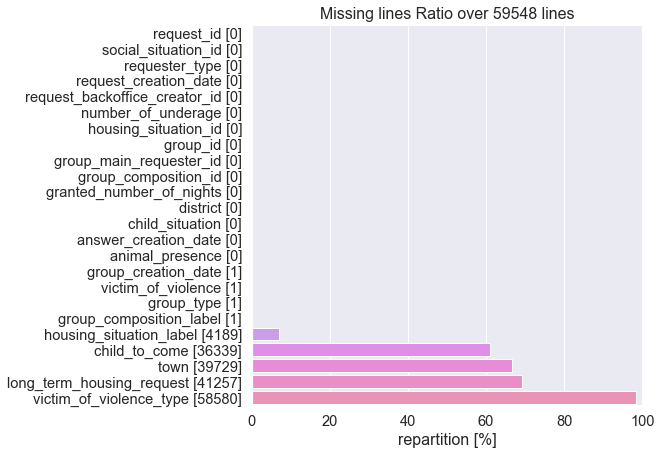

In [17]:
display_missing(requests_test)

### individuals_train

nb_missing      ratio
request_id                              0   0.000000
individual_id                           0   0.000000
housing_situation_2_id                  0   0.000000
housing_situation_2_label               0   0.000000
birth_month                             0   0.000000
birth_year                              0   0.000000
individual_role_2_id                    0   0.000000
marital_status_id                       0   0.000000
gender                                  1   0.000260
pregnancy                              14   0.003645
individual_role_2_label                55   0.014318
individual_creation_date            19700   5.128432
marital_status_label               102338  26.641294
disabled_worker_certification      254741  66.315833
individual_role                    301043  78.369471
childcare_center_supervision       378254  98.469540

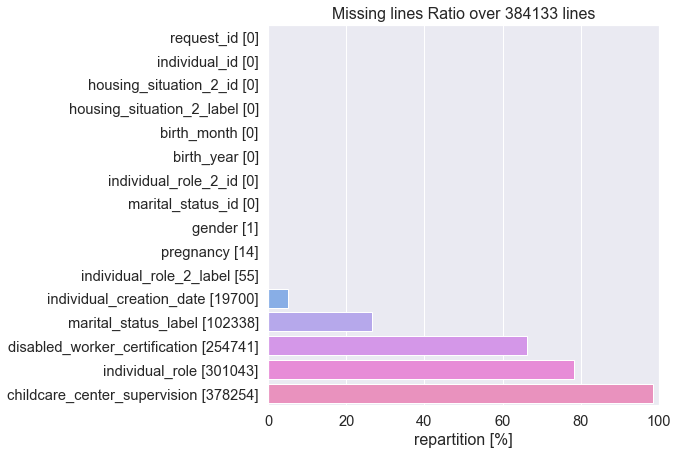

In [18]:
display_missing(individuals_train)

In [19]:
individuals_train.shape[0]

384133

In [20]:
individuals_train["request_id"].nunique()

238191

In [21]:
requests_train["request_id"].nunique()

238191

In [22]:
individuals_train["individual_id"].nunique()

83513

Several individuals for one request

And one individual can have multiple status (during time ?)

### individuals_test

nb_missing      ratio
request_id                              0   0.000000
individual_id                           0   0.000000
housing_situation_2_id                  0   0.000000
housing_situation_2_label               0   0.000000
birth_month                             0   0.000000
birth_year                              0   0.000000
individual_role_2_id                    0   0.000000
marital_status_id                       0   0.000000
gender                                  1   0.001046
pregnancy                               4   0.004182
individual_role_2_label                13   0.013592
individual_creation_date             4942   5.167240
marital_status_label                24872  26.005583
disabled_worker_certification       62986  65.856693
individual_role                     74938  78.353426
childcare_center_supervision        94187  98.479731

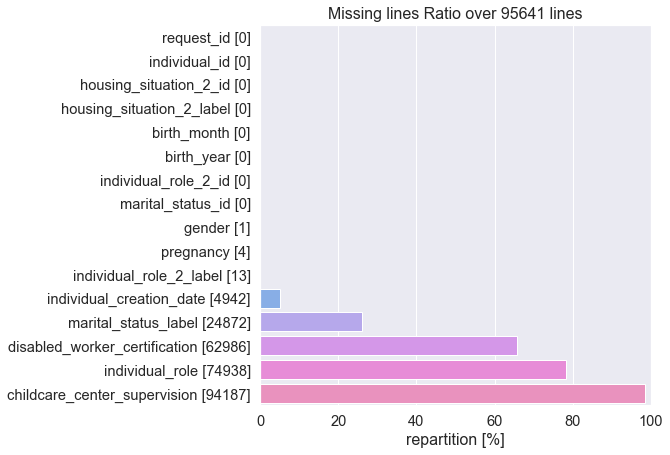

In [23]:
display_missing(individuals_test)

In [24]:
individuals_test.shape[0]

95641

In [25]:
individuals_test["request_id"].nunique()

59548

In [26]:
requests_test["request_id"].nunique()

59548

All request_id from requests_test are into individuals_test

In [27]:
individuals_test["individual_id"].nunique()

42915

## Correlations

### Correct housing_situation_label
Only label 170 is unkonwn => add a housing_situation_label = "unknown"


housing_situation_label have some impact on number of nights
So we must keep it and check Nan Value???

In [28]:
requests_train["housing_situation_id"].value_counts(dropna=False)

200    101885
10      68512
50      17052
170     16748
160      9340
120      9171
100      4238
110      2832
130      2170
80       1722
40        810
180       807
190       660
30        468
70        396
140       308
20        298
220       269
210       235
150       147
60         85
90         38
Name: housing_situation_id, dtype: int64

In [29]:
requests_train["housing_situation_id"].nunique()

22

In [30]:
requests_train["housing_situation_label"].nunique() 

21

In [31]:
requests_train[requests_train["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    16748
Name: housing_situation_id, dtype: int64

In [32]:
requests_test[requests_test["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    4189
Name: housing_situation_id, dtype: int64

In [33]:
requests_train[requests_train["housing_situation_label"].isna()]

request_id animal_presence  \
3       ae2d5b4dc181d29e430132f145da1556               f   
18      e7f5a33909899231d96518842d115f23               f   
30      9223b74676220e533c31db6af6a94103               f   
80      2d824ff45b8cdb87f2bc8e52ad97965f               f   
81      ad259fa68cc877c0d0813cbced0cefc9               f   
...                                  ...             ...   
238072  07d231ff2a7806ad6d10482d8afe3e40               f   
238087  0e2dbe3d86083c0b488809ed6fc505fc               f   
238101  8a4075d15ad94d1a476c190ed129b421               f   
238116  15749cfd95735a53128c9d03f3b11be5               f   
238163  6ae0c735f4b1b4bc318c4f25c2188410               f   

           answer_creation_date  child_situation child_to_come  district  \
3       2019-02-25 15:12:05.037               -1           NaN        50   
18      2019-02-28 09:35:23.766               -1           NaN        64   
30      2019-02-28 18:14:35.252               -1           NaN        51   
80       2019-02-11 20:01:57.84               -1           NaN        51   
81          2019-02-11 16:00:00               -1           NaN        26   
...                         ...              ...           ...       ...   
238072  2019-01-15 10:25:22.534               -1             f        50   
238087      2019-01-21 13:06:00               -1           NaN        17   
238101  2019-01-25 22:37:11.675               -1             f        63   
238116  2019-01-03 15:34:06.869               -1           NaN        17   
238163  2019-01-23 03:58:09.819               -1           NaN    315710   

        granted_number_of_nights  group_composition_id  \
3                              2                    20   
18                             0                    10   
30                             1                    10   
80                             0                    10   
81                             1                    10   
...                          ...                   ...   
238072                         0                    10   
238087                         0                    10   
238101                         0                    20   
238116                         2                    20   
238163                         1                    20   

       group_composition_label      group_creation_date  ...  \
3                  woman alone  2018-10-09 14:37:29.773  ...   
18                   man alone  2018-11-13 12:02:02.667  ...   
30                   man alone  2019-02-18 20:16:56.112  ...   
80                   man alone  2018-09-11 13:10:40.766  ...   
81                   man alone  2018-02-13 09:05:59.542  ...   
...                        ...                      ...  ...   
238072               man alone  2017-03-16 00:00:00.000  ...   
238087               man alone  2018-08-22 09:41:26.198  ...   
238101             woman alone  2018-07-01 20:40:38.068  ...   
238116             woman alone  2018-12-07 09:28:41.166  ...   
238163             woman alone  2018-12-27 19:19:55.924  ...   

       housing_situation_label long_term_housing_request number_of_underage  \
3                          NaN                       NaN                 -1   
18                         NaN                       NaN                 -1   
30                         NaN                       NaN                 -1   
80                         NaN                       NaN                 -1   
81                         NaN                       NaN                 -1   
...                        ...                       ...                ...   
238072                     NaN                         f                  0   
238087                     NaN                       NaN                 -1   
238101                     NaN                       NaN                 -1   
238116                     NaN                       NaN                 -1   
238163                     NaN                       NaN     

In [34]:
requests_train.loc[requests_train["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [35]:
requests_train[requests_train["housing_situation_label"].isna()]

Empty DataFrame
Columns: [request_id, animal_presence, answer_creation_date, child_situation, child_to_come, district, granted_number_of_nights, group_composition_id, group_composition_label, group_creation_date, group_id, group_main_requester_id, group_type, housing_situation_id, housing_situation_label, long_term_housing_request, number_of_underage, request_backoffice_creator_id, request_creation_date, requester_type, social_situation_id, town, victim_of_violence, victim_of_violence_type]
Index: []

[0 rows x 24 columns]

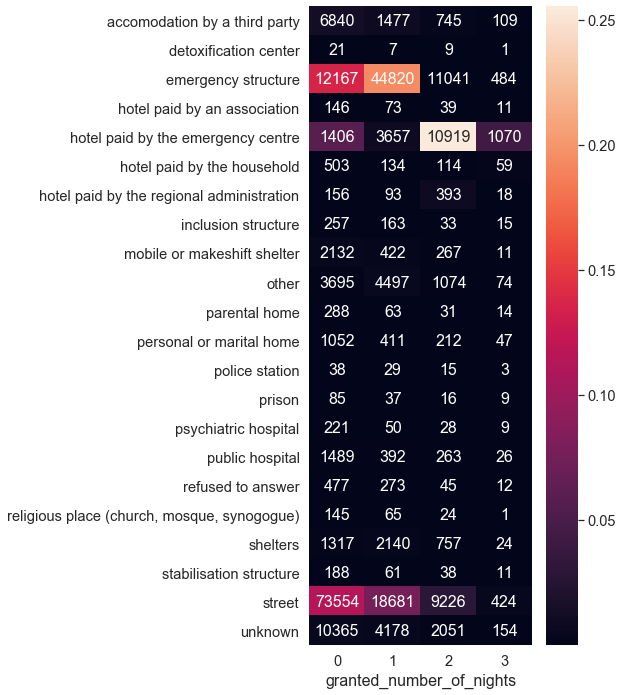

In [36]:
plot_cont(X="housing_situation_label",
    Y="granted_number_of_nights",
    data=requests_train)

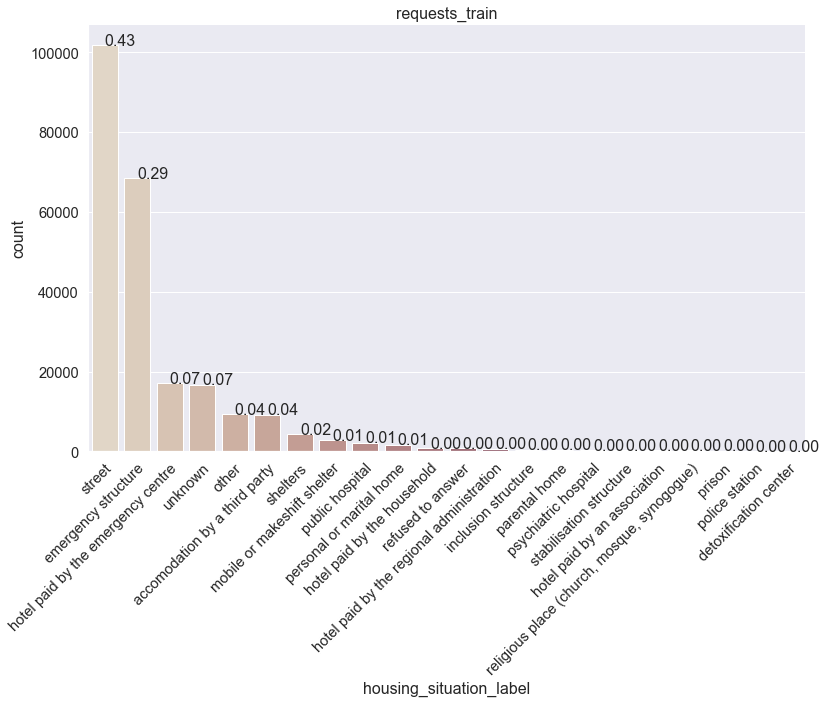

In [37]:
plot_hist_cat(x="housing_situation_label", data=requests_train, 
              title="requests_train")

In [38]:
requests_test.loc[requests_test["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [39]:
requests_test[requests_test["housing_situation_label"].isna()]

Empty DataFrame
Columns: [request_id, animal_presence, answer_creation_date, child_situation, child_to_come, district, granted_number_of_nights, group_composition_id, group_composition_label, group_creation_date, group_id, group_main_requester_id, group_type, housing_situation_id, housing_situation_label, long_term_housing_request, number_of_underage, request_backoffice_creator_id, request_creation_date, requester_type, social_situation_id, town, victim_of_violence, victim_of_violence_type]
Index: []

[0 rows x 24 columns]

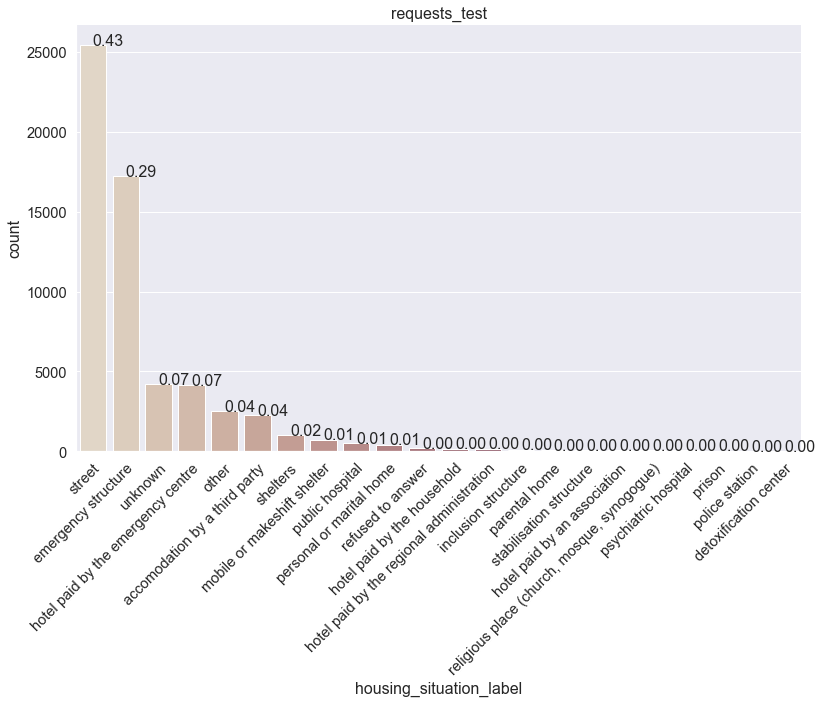

In [40]:
plot_hist_cat(x="housing_situation_label", data=requests_test, 
              title="requests_test")

In [41]:
requests_train["housing_situation_label"].nunique()

22

In [42]:
requests_test["housing_situation_label"].nunique()

22

In [43]:
requests_train["housing_situation_label"].unique()

array(['other', 'street', 'unknown', 'hotel paid by the emergency centre',
       'emergency structure', 'accomodation by a third party',
       'personal or marital home', 'parental home',
       'mobile or makeshift shelter', 'hotel paid by the household',
       'hotel paid by an association', 'stabilisation structure',
       'psychiatric hospital', 'shelters',
       'hotel paid by the regional administration', 'public hospital',
       'refused to answer', 'prison', 'inclusion structure',
       'religious place (church, mosque, synogogue)', 'police station',
       'detoxification center'], dtype=object)

In [44]:
requests_test["housing_situation_label"].unique()

array(['street', 'public hospital', 'emergency structure', 'unknown',
       'hotel paid by the household', 'accomodation by a third party',
       'hotel paid by the emergency centre', 'other', 'shelters',
       'personal or marital home', 'stabilisation structure',
       'hotel paid by the regional administration',
       'hotel paid by an association', 'inclusion structure',
       'mobile or makeshift shelter', 'prison', 'detoxification center',
       'refused to answer', 'parental home',
       'religious place (church, mosque, synogogue)', 'police station',
       'psychiatric hospital'], dtype=object)

Check if same ensemble of labels in Test and Train : 

In [45]:
print('Colonnes dans Train et pas dans Test : ')
set(requests_train["housing_situation_label"].unique().tolist()) \
    .difference(requests_test["housing_situation_label"].unique().tolist())

Colonnes dans Train et pas dans Test : 


set()

In [46]:
print('Colonnes dans Test et pas dans Train : ')
set(requests_test["housing_situation_label"].unique().tolist()) \
    .difference(requests_train["housing_situation_label"].unique().tolist())

Colonnes dans Test et pas dans Train : 


set()

=> OK same

Check if one individual of a group can represent the housing situation of group : 

For that, check if there is only 1 housing_situation_2_id for all individuals linked to 1 request into individuals_train & individuals_test.

In [47]:
individuals_train["housing_situation_2_id"].nunique()

28

In [48]:
individuals_train["housing_situation_2_id"].value_counts(dropna=False)

20    289870
35     39716
32     14872
47     14479
29      6694
44      6449
22      2599
36      2413
30      1602
34      1332
26       953
37       494
23       437
38       365
28       280
42       271
27       243
21       236
31       223
46       173
45       146
40        89
33        81
25        46
43        32
39        21
24        15
41         2
Name: housing_situation_2_id, dtype: int64

In [49]:
individuals_train["housing_situation_2_label"].value_counts(dropna=False)

on the street                                      289870
hotel paid by the emergency structure               39716
emergency accomodation                              14872
day center, social services, associations           14479
accomodated by friends or other                      6694
other                                                6449
reception center for asylum seeker                   2599
public instition (hospital, retirement home)         2413
accomodated by family                                1602
hotel not paid by an emergency structure             1332
winter plan center                                    953
private housing rental                                494
emergency accomodation centre for asylum seeker       437
public housing rental                                 365
residential roaming                                   280
child care                                            271
medical centre                                        243
emergency cent

In [50]:
individuals_train["request_id"].nunique()

238191

In [51]:
individuals_train.shape[0]

384133

In [52]:
def fun_check_unique(id_curr):
    list_id = individuals_train[individuals_train["request_id"] == \
                         id_curr]["housing_situation_2_id"].values
    return np.all(list_id == list_id[0])
#requests_train["flag_unique_hs"] = \
#    requests_train["request_id"].apply(fun_check_unique)

In [53]:
def fun_nunique(serie_in):
    return serie_in.nunique()

pt_req_hs_nb = pd.pivot_table(individuals_train, 
                              values='housing_situation_2_id', 
               index=['request_id'], aggfunc=fun_nunique)
pt_req_hs_nb

housing_situation_2_id
request_id                                              
0000602749161524aedd04269957e5fc                       1
0000c66f6bb24e930cba6a3872d3ab02                       1
0000dbd253c096eab97cab0545915ab2                       1
0001826bdd626262ec2bda3a1b908aac                       1
0001925b4cd4d65110638ee3d5f2f454                       1
...                                                  ...
fffd7c7c22a9147bc4af4b869eb97f19                       1
fffeeac2155c826f0ccc2f912c1049f9                       1
fffeff160a0bf8c160c9e63436273cec                       1
ffff40d1408c4f032e1047adab9fbf93                       1
ffff8a617e122d989a9024a9c09fd622                       1

[238191 rows x 1 columns]

In [54]:
pt_req_hs_nb["housing_situation_2_id"].value_counts()

1    238191
Name: housing_situation_2_id, dtype: int64

In [55]:
pt_req_hs_nb_test = pd.pivot_table(individuals_test, 
                              values='housing_situation_2_id', 
                              index=['request_id'], 
                              aggfunc=fun_nunique)
pt_req_hs_nb_test

housing_situation_2_id
request_id                                              
00025115a1823cf8dc4e405fac55aa08                       1
000329aa7e358635d26ff2d82a3f51d9                       1
00035ca76ed77fd146fbd433fdccd8a5                       1
0004db4b2bf9997bbd68d59c5c4d65a5                       1
00072464a3949529d9093a7622806527                       1
...                                                  ...
fffd6850c8daf68dcdf737647952f40d                       1
fffe858cbae1fcf6093a9676d81119d9                       1
fffec8a1dff845182d68e56ed8329a37                       1
ffff982c528b9dbd87da975d8a44c2bc                       1
ffffa1498a6f2bd46a2dbb5f76bcab43                       1

[59548 rows x 1 columns]

In [56]:
pt_req_hs_nb_test["housing_situation_2_id"].value_counts()

1    59548
Name: housing_situation_2_id, dtype: int64

=> Every request in individual tables have only one housing_situation

We can use it directly to add data into request table (for missing values)

We can also add a data column (feature) with these information for future use

Create table to link request id with one unique housing_situation_2_id : 

In [57]:
def fun_first(serie_in):
    return serie_in.values[0]

pt_req_hs_train = pd.pivot_table(individuals_train, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)

pt_req_hs_test = pd.pivot_table(individuals_test, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)
pt_req_hs_train

housing_situation_2_label
request_id                                                                 
0000602749161524aedd04269957e5fc                              on the street
0000c66f6bb24e930cba6a3872d3ab02                              on the street
0000dbd253c096eab97cab0545915ab2                              on the street
0001826bdd626262ec2bda3a1b908aac                              on the street
0001925b4cd4d65110638ee3d5f2f454                              on the street
...                                                                     ...
fffd7c7c22a9147bc4af4b869eb97f19                              on the street
fffeeac2155c826f0ccc2f912c1049f9                              on the street
fffeff160a0bf8c160c9e63436273cec                     emergency accomodation
ffff40d1408c4f032e1047adab9fbf93  day center, social services, associations
ffff8a617e122d989a9024a9c09fd622                     emergency accomodation

[238191 rows x 1 columns]

Join this data  to request tables : 

In [58]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_hs_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                   other   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                   other   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                              2  \
request_id                     12cc0a18890bd4959fe42df3ae58838e   
animal_presence                                               f   
answer_creation_date                        2019-02-01 21:00:00   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     59   
granted_number_of_nights                                      1   
group_composition_id                    

In [61]:
df_test.shape

(238191, 25)

In [60]:
requests_train = df_test.copy()

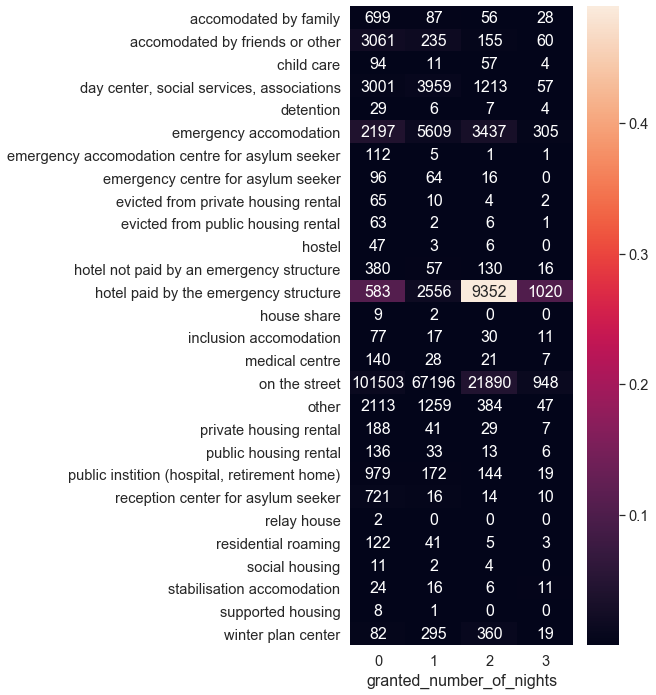

In [62]:
plot_cont(X="housing_situation_2_label",
Y="granted_number_of_nights",
data=requests_train)

In [63]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_hs_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                              2  \
request_id                     415696df2fef0b6a4d7e07b36d12dc7f   
animal_presence                                               f   
answer_creation_date                    2019-02-27 09:53:34.537   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                    100   
granted_number_of_nights                                      0   
group_composition_id                    

In [64]:
df_test.shape

(59548, 25)

In [65]:
requests_test.shape

(59548, 24)

In [66]:
requests_test = df_test.copy()

To not add too mush dimensions to features list for model, 

we choose to correct data from requests tables by information from individuals tables

unknown and other requests housing label will be translate in requests tables existing label.

List of corresponding label if label = other :

In [67]:
requests_train[requests_train["housing_situation_label"] == 'other'] \
    ["housing_situation_2_label"].unique().tolist()

['on the street',
 'other',
 'day center, social services, associations',
 'public instition (hospital, retirement home)',
 'public housing rental',
 'reception center for asylum seeker',
 'residential roaming',
 'emergency accomodation',
 'hotel not paid by an emergency structure',
 'evicted from private housing rental',
 'medical centre',
 'accomodated by friends or other',
 'child care',
 'emergency accomodation centre for asylum seeker',
 'detention',
 'winter plan center',
 'hotel paid by the emergency structure',
 'accomodated by family',
 'inclusion accomodation',
 'evicted from public housing rental',
 'stabilisation accomodation',
 'social housing',
 'hostel',
 'emergency centre for asylum seeker',
 'house share',
 'private housing rental']

In [68]:
requests_train["housing_situation_label"].unique().tolist()

['other',
 'street',
 'unknown',
 'hotel paid by the emergency centre',
 'emergency structure',
 'accomodation by a third party',
 'personal or marital home',
 'parental home',
 'mobile or makeshift shelter',
 'hotel paid by the household',
 'hotel paid by an association',
 'stabilisation structure',
 'psychiatric hospital',
 'shelters',
 'hotel paid by the regional administration',
 'public hospital',
 'refused to answer',
 'prison',
 'inclusion structure',
 'religious place (church, mosque, synogogue)',
 'police station',
 'detoxification center']

In [69]:
val_count = requests_train[requests_train["housing_situation_2_label"] == \
                'day center, social services, associations'] \
    ["housing_situation_label"].value_counts()
val_count

emergency structure                            3680
street                                         1431
unknown                                         920
shelters                                        761
accomodation by a third party                   388
other                                           304
hotel paid by the emergency centre              152
personal or marital home                        146
mobile or makeshift shelter                     119
public hospital                                 103
refused to answer                                50
hotel paid by the household                      34
inclusion structure                              28
parental home                                    23
hotel paid by an association                     22
stabilisation structure                          18
religious place (church, mosque, synogogue)      13
police station                                   11
hotel paid by the regional administration        10
prison      

In [70]:
val_count.index[0]

'emergency structure'

In [71]:
requests_train[requests_train["housing_situation_label"] == \
               "detoxification center"].T

26632   \
request_id                     cd016d5d25ed25f1f96be819cf71bfc1   
animal_presence                                               f   
answer_creation_date                    2019-02-18 15:19:52.472   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     90   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-03-23 17:24:13.498   
group_id                       02f181adc79f0aa0c8a6adb94bb76a33   
group_main_requester_id        51eaf7c4ab917e6af2b0fe5e1c9eae46   
group_type                                           individual   
housing_situation_id                                         90   
housing_situation_label                   detoxification center   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  8b9cdb0c41b0fe196024b3b3172f3b35   
request_creation_date                   2019-02-18 15:19:52.472   
requester_type                                             user   
social_situation_id            e898f93fb9a3411a8d80829a12a08f39   
town                                                     Domats   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                         29504   \
request_id                     016d1b32e413536d7991d6ebcad6b53d   
animal_presence                                               f   
answer_creation_date                    2019-02-07 21:16:09.276   
child_situation                                              -1   
child_to_come                                                 f   
district                                                     95   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-07 21:23:29.737   
group_id                       f153ef50b2a50cbe9c11f941456a41aa   
group_main_requester_id        501c38d96a6bd04e40cbfbb6fe4595c6   
group_type                                           individual   
housing_situation_id                                         90   
housing_situation_label                   detoxification center   
long_term_housing_request                                     t   
number_of_underage                                            0   
request_backoffice_creator_id  3dd04044cdf1c7775a4191a521377bb9   
request_creation_date                   2019-02-07 21:16:09.276   
requester_type                                             user   
social_situation_id            18c38e05ff518ecb54e381489776fef3   
town                                                    Créteil   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   

                                                         34466   \
request_id                     7ee1595272126e3666f7d2ae652720c5   
animal_presence                                               f   
answer_creation_date                        2019-02-11 17:00:00   
child_situation                                              70   
child_to_come                                                 f   
district                                                     63   
granted_number_of_nights                                      2   
group_composition_id               

In [72]:
individuals_train[individuals_train["request_id"] \
                  == "cd016d5d25ed25f1f96be819cf71bfc1"].T

42592
request_id                     cd016d5d25ed25f1f96be819cf71bfc1
individual_id                  689374bd45d7911e77796e86eeb8938a
housing_situation_2_id                                       20
housing_situation_2_label                         on the street
birth_month                                                   6
birth_year                                                 1974
childcare_center_supervision                                NaN
disabled_worker_certification                               NaN
gender                                                     male
individual_creation_date                             2018-03-23
individual_role                                             NaN
individual_role_2_id                                         30
individual_role_2_label                          isolated adult
marital_status_id                                            10
marital_status_label                              single person
pregnancy                                                     f

Create a dictionnary with most represented  housing_situation_label linked with housing_situation_2_label into database request : 

In [73]:
dict_conv_hs = {}
for label_curr in requests_train["housing_situation_2_label"].unique().tolist():
    val_count = requests_train[requests_train["housing_situation_2_label"] == \
                label_curr] \
        ["housing_situation_label"].value_counts()
    label_most_rep = val_count.index[0]
    dict_conv_hs[label_curr] = label_most_rep
dict_conv_hs

{'on the street': 'street',
 'hotel paid by the emergency structure': 'hotel paid by the emergency centre',
 'accomodated by friends or other': 'accomodation by a third party',
 'private housing rental': 'personal or marital home',
 'other': 'other',
 'child care': 'shelters',
 'day center, social services, associations': 'emergency structure',
 'accomodated by family': 'accomodation by a third party',
 'medical centre': 'public hospital',
 'emergency accomodation': 'emergency structure',
 'public instition (hospital, retirement home)': 'public hospital',
 'inclusion accomodation': 'inclusion structure',
 'winter plan center': 'emergency structure',
 'hotel not paid by an emergency structure': 'hotel paid by the household',
 'public housing rental': 'personal or marital home',
 'reception center for asylum seeker': 'shelters',
 'residential roaming': 'accomodation by a third party',
 'supported housing': 'personal or marital home',
 'emergency centre for asylum seeker': 'street',
 'hos

In [74]:
def fun_conv_hs(str_in):
    try:
        if str_in in dict_conv_hs.keys():
            return dict_conv_hs[str_in]
        else:
            return str_in
    except: 
        
       #print(str_in, " not found !")
        return str_in

df_test = requests_train.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  26088
Nb. other/unknown labels after :  2065


In [75]:
requests_train.shape

(238191, 25)

In [76]:
df_test.shape

(238191, 25)

In [77]:
requests_train = df_test.copy()

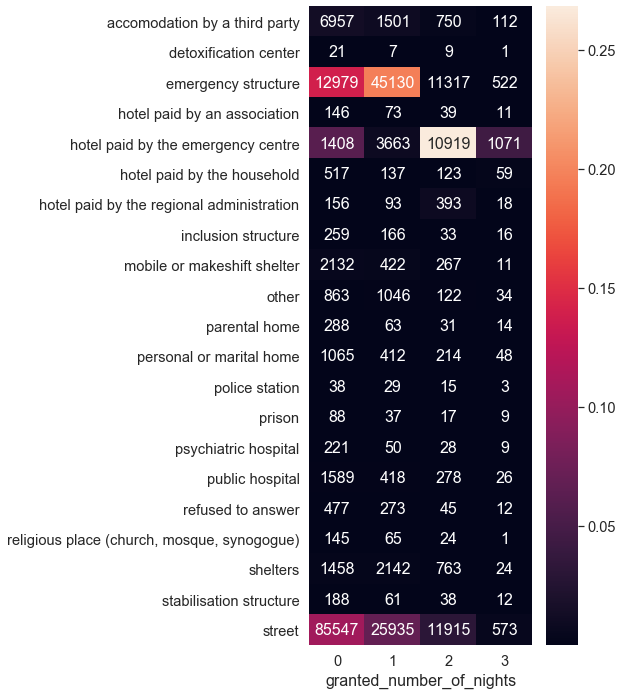

In [78]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_train)

Finally, unknown can be convert in other because not a lot of impact :

In [79]:
bol_unknown = requests_train["housing_situation_label"] == 'unknown'
requests_train.loc[bol_unknown, "housing_situation_label"] = "other"

For Test database :

In [80]:
df_test = requests_test.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  6692
Nb. other/unknown labels after :  532


In [81]:
requests_test.shape

(59548, 25)

In [82]:
df_test.shape

(59548, 25)

In [83]:
requests_test = df_test.copy()

In [84]:
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown before : ", requests_test[bol_unknown].shape[0])
requests_test.loc[bol_unknown, "housing_situation_label"] = "other"
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown after : ", requests_test[bol_unknown].shape[0])

Nb. unknown before :  0
Nb. unknown after :  0


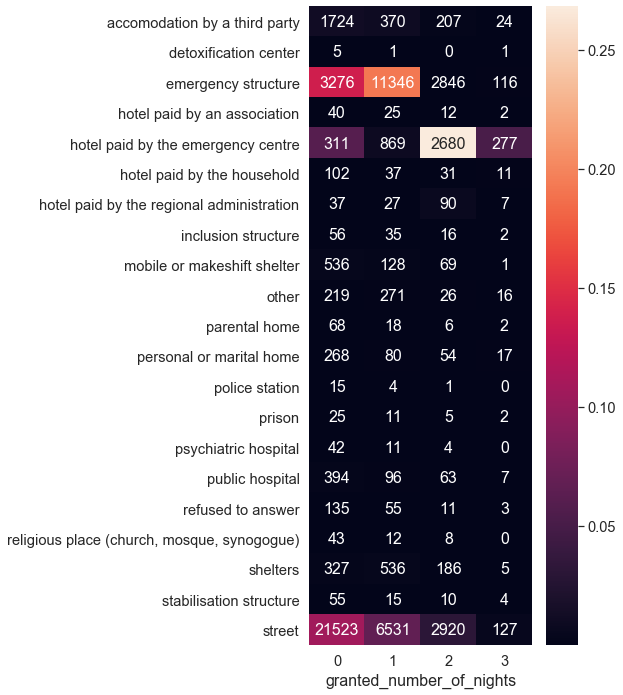

In [85]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_test)

In [86]:
# check in no Nan
bol_nan = requests_train["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_train[bol_nan].shape[0])
bol_nan = requests_test["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_test[bol_nan].shape[0])

TRAIN : Nb. nan values =  0
TRAIN : Nb. nan values =  0


=> OK cleaning done

We can use "housing_situation_label" as feature

### child to come or pregnancy

In [87]:
requests_train["child_to_come"].value_counts(dropna=False)

NaN    145947
f       85878
t        6366
Name: child_to_come, dtype: int64

In [88]:
requests_train.loc[requests_train["child_to_come"].isna(),
                   "child_to_come"] = "unknown"

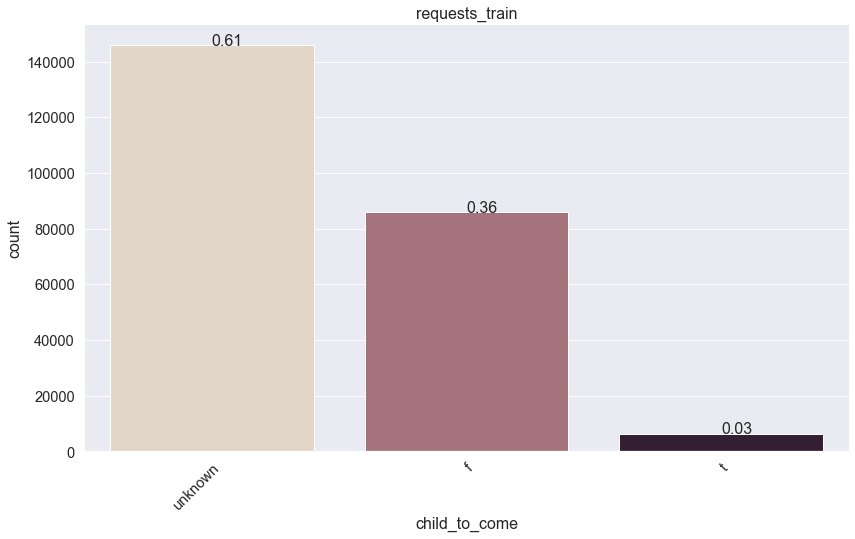

In [89]:
plot_hist_cat(x="child_to_come", data=requests_train, 
              title="requests_train")

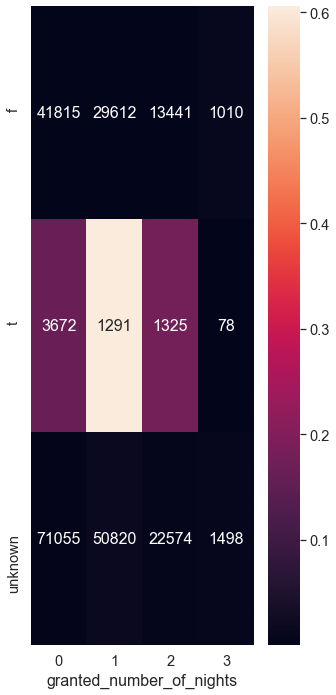

In [90]:
plot_cont(X="child_to_come", Y="granted_number_of_nights", data=requests_train)

=> dependency when True.

Find info in individuals tables : 

In [91]:
individuals_train["pregnancy"].value_counts(dropna=False)

f      372930
t       11189
NaN        14
Name: pregnancy, dtype: int64

In [92]:
def fun_pregnancy(serie_in):
    if ("t" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_preg_train = pd.pivot_table(individuals_train, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_train

pregnancy
request_id                                
0000602749161524aedd04269957e5fc         f
0000c66f6bb24e930cba6a3872d3ab02         f
0000dbd253c096eab97cab0545915ab2         f
0001826bdd626262ec2bda3a1b908aac         f
0001925b4cd4d65110638ee3d5f2f454         f
...                                    ...
fffd7c7c22a9147bc4af4b869eb97f19         f
fffeeac2155c826f0ccc2f912c1049f9         f
fffeff160a0bf8c160c9e63436273cec         f
ffff40d1408c4f032e1047adab9fbf93         f
ffff8a617e122d989a9024a9c09fd622         f

[238191 rows x 1 columns]

In [93]:
pt_req_preg_train["pregnancy"].value_counts(dropna=False)

f    227012
t     11179
Name: pregnancy, dtype: int64

Same for Test :

In [94]:
individuals_test["pregnancy"].value_counts(dropna=False)

f      92839
t       2798
NaN        4
Name: pregnancy, dtype: int64

In [95]:
pt_req_preg_test = pd.pivot_table(individuals_test, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_test

pregnancy
request_id                                
00025115a1823cf8dc4e405fac55aa08         f
000329aa7e358635d26ff2d82a3f51d9         f
00035ca76ed77fd146fbd433fdccd8a5         f
0004db4b2bf9997bbd68d59c5c4d65a5         f
00072464a3949529d9093a7622806527         f
...                                    ...
fffd6850c8daf68dcdf737647952f40d         f
fffe858cbae1fcf6093a9676d81119d9         t
fffec8a1dff845182d68e56ed8329a37         f
ffff982c528b9dbd87da975d8a44c2bc         f
ffffa1498a6f2bd46a2dbb5f76bcab43         f

[59548 rows x 1 columns]

Add data to request tables

In [96]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_preg_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   
pregnancy                                                     f   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   
pregnancy                                                     f   

                                                              2  \
request_id                     12cc0a18890bd4959fe42df3ae58838e   
animal_presence                                               f   
answer_creation_date                        2019-02-01 21:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                

In [97]:
requests_train.shape

(238191, 25)

In [98]:
df_test.shape

(238191, 26)

In [99]:
requests_train = df_test.copy()

Same for Test :

In [100]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_preg_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   
pregnancy                                                     f   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                                   NaN   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                     NaN   
housing_situation_2_label                         on the street   
pregnancy                                                     f   

                                                              2  \
request_id                     415696df2fef0b6a4d7e07b36d12dc7f   
animal_presence                                               f   
answer_creation_date                    2019-02-27 09:53:34.537   
child_situation                                              -1   
child_to_come                                               NaN   
district                                

In [101]:
requests_test.shape

(59548, 25)

In [102]:
df_test.shape

(59548, 26)

In [103]:
requests_test = df_test.copy()

Check validity : 

if pregnancy True, child_to_come True ?

In [104]:
requests_train[requests_train["pregnancy"] == 't'] \
    ["child_to_come"].value_counts()

unknown    5375
t          4414
f          1390
Name: child_to_come, dtype: int64

In [105]:
requests_train[requests_train["pregnancy"] == 'f'] \
    ["child_to_come"].value_counts()

unknown    140572
f           84488
t            1952
Name: child_to_come, dtype: int64

In [106]:
requests_train[requests_train["child_to_come"] == 't'] \
    ["pregnancy"].value_counts()

t    4414
f    1952
Name: pregnancy, dtype: int64

In [107]:
requests_train[requests_train["child_to_come"] == 'f'] \
    ["pregnancy"].value_counts()

f    84488
t     1390
Name: pregnancy, dtype: int64

In [108]:
requests_train[requests_train["child_to_come"] == 'unknown'] \
    ["pregnancy"].value_counts()

f    140572
t      5375
Name: pregnancy, dtype: int64

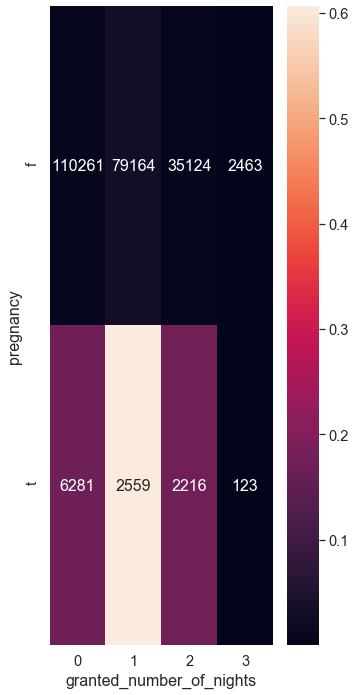

In [109]:
plot_cont(X="pregnancy", Y="granted_number_of_nights", data=requests_train)

=> We can take "pregnancy" as feature because less nan values and keep information
(although data "child_to_come" is not exactly the same as pregnancy)

### Localization

In [110]:
#individuals_train
requests_train["town"].value_counts(dropna=False)

NaN                        159959
Saint-Étienne                4549
Amiens                       3900
Nantes                       3820
Lyon                         3643
                            ...  
Le Porge                        1
Dijon                           1
La Neuville-sur-Ressons         1
Guer                            1
Fénétrange                      1
Name: town, Length: 1117, dtype: int64

In [111]:
requests_train[requests_train["town"].notna()].shape[0]

78232

In [112]:
'''geolocator = Nominatim(user_agent="data-science-test")
location = geolocator.geocode("Bornel")
print(location.address)
location.raw'''

'geolocator = Nominatim(user_agent="data-science-test")\nlocation = geolocator.geocode("Bornel")\nprint(location.address)\nlocation.raw'

In [113]:
requests_train["district"].value_counts(dropna=False)

70        12400
68        11442
13        10567
60         9732
93         7985
          ...  
19           21
98           19
48            5
315770        4
315842        1
Name: district, Length: 102, dtype: int64

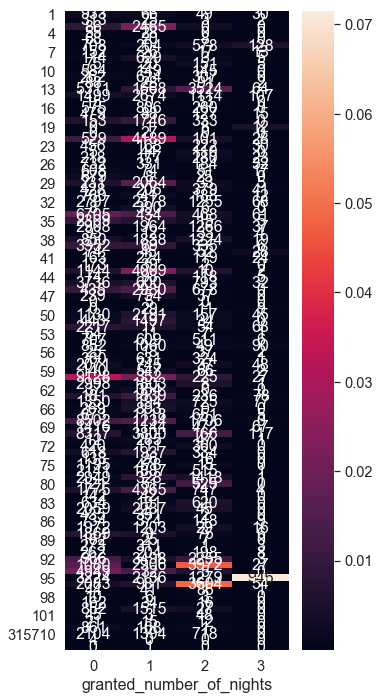

In [114]:
plot_cont(X="district", Y="granted_number_of_nights", data=requests_train)

=> There is some information into town because distribution of number of nights depends on town.

Check if district = french "departement" :

In [115]:
df_dep = pd.read_csv(filepath_or_buffer=PATH_TO_DEP,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_dep

id region_code code                                         name  \
0      1          84   01                                          Ain   
1      2          32   02                                        Aisne   
2      3          84   03                                       Allier   
3      4          93   04                      Alpes-de-Haute-Provence   
4      5          93   05                                 Hautes-Alpes   
..   ...         ...  ...                                          ...   
104  105         COM  984  Terres australes et antarctiques françaises   
105  106         COM  986                             Wallis et Futuna   
106  107         COM  987                          Polynésie française   
107  108         COM  988                           Nouvelle-Calédonie   
108  109         COM  989                            Île de Clipperton   

                                            slug  
0                                            ain  
1                                          aisne  
2                                         allier  
3                        alpes de haute provence  
4                                   hautes alpes  
..                                           ...  
104  terres australes et antarctiques francaises  
105                             wallis et futuna  
106                          polynesie francaise  
107                           nouvelle caledonie  
108                            ile de clipperton  

[109 rows x 5 columns]

In [116]:
df_cit = pd.read_csv(filepath_or_buffer=PATH_TO_CIT,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_cit

id department_code insee_code  zip_code                     name  \
0          1              01      01001    1400.0  L'Abergement-Clémenciat   
1          2              01      01002    1640.0    L'Abergement-de-Varey   
2          3              01      01004    1500.0        Ambérieu-en-Bugey   
3          4              01      01005    1330.0      Ambérieux-en-Dombes   
4          5              01      01006    1300.0                  Ambléon   
...      ...             ...        ...       ...                      ...   
35848  35849             988        NaN   98831.0                    Touho   
35849  35850             988        NaN   98833.0                      Voh   
35850  35851             988        NaN   98834.0                     Yaté   
35851  35852             988        NaN   98818.0                  Kouaoua   
35852  35853             989        NaN       NaN        Île de Clipperton   

                          slug    gps_lat     gps_lng  
0      l abergement clemenciat  46.156782    4.924699  
1        l abergement de varey  46.010086    5.428759  
2            amberieu en bugey  45.958409    5.375992  
3          amberieux en dombes  46.000120    4.910602  
4                      ambleon  45.746427    5.602492  
...                        ...        ...         ...  
35848                    touho -20.780538  165.232815  
35849                      voh -20.949963  164.687186  
35850                     yate -22.159370  166.944270  
35851                  kouaoua -21.396181  165.828447  
35852        ile de clipperton  10.303647 -109.216322  

[35853 rows x 8 columns]

In [117]:
requests_train[requests_train["town"] == "Grigny"]["district"].value_counts()

92    375
95      1
Name: district, dtype: int64

In [118]:
df_cit[df_cit["name"] == "Grigny"]["department_code"]

24442    62
27652    69
35182    91
Name: department_code, dtype: object

In [119]:
df_cit[df_cit["name"] == "Grigny"]

id department_code insee_code  zip_code    name    slug    gps_lat  \
24442  24443              62      62388   62140.0  Grigny  grigny  50.385548   
27652  27653              69      69096   69520.0  Grigny  grigny  45.612089   
35182  35183              91      91286   91350.0  Grigny  grigny  48.653582   

        gps_lng  
24442  2.058399  
27652  4.784562  
35182  2.388497

In [120]:
requests_train[requests_train["town"].notna()]["town"]

12                     Reims
14                    Rennes
23                  Bordeaux
26          Corbeil-Essonnes
31        Bruay-la-Buissière
                 ...        
238179        Roissy-en-Brie
238181               Quimper
238184            Versailles
238189                Grigny
238190         Aubervilliers
Name: town, Length: 78232, dtype: object

In [121]:
requests_train[requests_train["town"] == "Reims"]["district"].value_counts()

52    1131
58      22
64      16
8        7
57       3
61       2
45       2
29       2
13       2
93       1
70       1
68       1
60       1
18       1
6        1
2        1
Name: district, dtype: int64

In [122]:
df_cit[df_cit["name"] == "Reims"]["department_code"]

19040    51
Name: department_code, dtype: object

=> NOK : district number is different than departement code.

Check if some district doesn't have any towns in database : 

Find most used town for each District 

In [123]:
def fun_find_town(list_in):
    val_c = list_in.value_counts(dropna=True)
    if len(val_c) > 0:
        return val_c.index[0]
    else:
        return np.nan 
    
pt_dis_town_train = pd.pivot_table(requests_train, 
                              values='town', index=['district'], 
                                   aggfunc=fun_find_town, dropna=False)
pt_dis_town_train

town
district               
1                  Lyon
2         Saint-Quentin
3             Périgueux
4                   NaN
5                  Metz
...                 ...
314550              NaN
315670             Lyon
315710             Caen
315770     Saint-Martin
315842              NaN

[102 rows x 1 columns]

In [124]:
pt_dis_town_train.shape[0]

102

In [125]:
print("Nb district without town : ", 
      pt_dis_town_train[pt_dis_town_train["town"].isna()].shape[0])

Nb district without town :  5


In [139]:
pt_dis_town_train[pt_dis_town_train["town"].isna()]

town
district     
4         NaN
9         NaN
101       NaN
314550    NaN
315842    NaN

In [140]:
list_d_0 = pt_dis_town_train[pt_dis_town_train["town"].isna()].index.tolist()

In [257]:
print("Nb of sample in Train using a District without any Town :")
len([elem for elem in requests_train["district"] if elem in list_d_0])

Nb of sample in Train using a District without any Town :


479

=> We have to define another region area to have the less impact

For Test : 

In [275]:
pt_dis_town_test = pd.pivot_table(requests_test, 
                              values='town', index=['district'], 
                                   aggfunc=fun_find_town,  dropna=False)
pt_dis_town_test["district"] = pt_dis_town_test.index
pt_dis_town_test

town  district
district                         
1         Saint-Étienne         1
2              Soissons         2
3             Périgueux         3
4                   NaN         4
5             Marseille         5
...                 ...       ...
101                 NaN       101
314550              NaN    314550
315670        Angoulême    315670
315710             Caen    315710
315770     Saint-Martin    315770

[101 rows x 2 columns]

In [276]:
print("Nb district without town in Test : ", 
      pt_dis_town_test[pt_dis_town_test["town"].isna()].shape[0])

Nb district without town in Test :  9


In [277]:
pt_dis_town_test[pt_dis_town_test["town"].isna()]

town  district
district               
4         NaN         4
9         NaN         9
19        NaN        19
33        NaN        33
42        NaN        42
48        NaN        48
98        NaN        98
101       NaN       101
314550    NaN    314550

In [130]:
pt_dis_town = pt_dis_town_train.join(pt_dis_town_test, on="district", 
                                     rsuffix='_test')

In [131]:
pt_dis_town

town      town_test
district                              
1                  Lyon  Saint-Étienne
2         Saint-Quentin       Soissons
3             Périgueux      Périgueux
4                   NaN            NaN
5                  Metz      Marseille
...                 ...            ...
314550              NaN            NaN
315670             Lyon      Angoulême
315710             Caen           Caen
315770     Saint-Martin   Saint-Martin
315842              NaN            NaN

[102 rows x 2 columns]

Check if we can add information with Test data ?

In [278]:
pt_dis_town[pt_dis_town["town"].isna() & pt_dis_town["town_test"].notna()]

Empty DataFrame
Columns: [town, town_test, district, department_code, code_x, region_code, code_y, region]
Index: []

=> NO : no info about town into district 

And using data in Test could be a data leak !

We can try to reduce categorical data (102 dimensions) into area geographical data  (regions) : 
For that we use Town to find the Departement number, and after the region code/name

Sources : https://www.data.gouv.fr/fr/datasets/regions-departements-villes-et-villages-de-france-et-doutre-mer/

In [152]:
df_reg = pd.read_csv(filepath_or_buffer=PATH_TO_REG,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_reg


id code                        name                       slug
0    1   01                  Guadeloupe                 guadeloupe
1    2   02                  Martinique                 martinique
2    3   03                      Guyane                     guyane
3    4   04                  La Réunion                 la reunion
4    5   06                     Mayotte                    mayotte
5    6   11               Île-de-France              ile de france
6    7   24         Centre-Val de Loire        centre val de loire
7    8   27     Bourgogne-Franche-Comté    bourgogne franche comte
8    9   28                   Normandie                  normandie
9   10   32             Hauts-de-France            hauts de france
10  11   44                   Grand Est                  grand est
11  12   52            Pays de la Loire           pays de la loire
12  13   53                    Bretagne                   bretagne
13  14   75          Nouvelle-Aquitaine         nouvelle aquitaine
14  15   76                   Occitanie                  occitanie
15  16   84        Auvergne-Rhône-Alpes       auvergne rhone alpes
16  17   93  Provence-Alpes-Côte d'Azur  provence alpes cote dazur
17  18   94                       Corse                      corse
18  19  COM   Collectivités d'Outre-Mer   collectivites doutre mer

In [153]:
df_cit

id department_code insee_code  zip_code                     name  \
0          1              01      01001    1400.0  L'Abergement-Clémenciat   
1          2              01      01002    1640.0    L'Abergement-de-Varey   
2          3              01      01004    1500.0        Ambérieu-en-Bugey   
3          4              01      01005    1330.0      Ambérieux-en-Dombes   
4          5              01      01006    1300.0                  Ambléon   
...      ...             ...        ...       ...                      ...   
35848  35849             988        NaN   98831.0                    Touho   
35849  35850             988        NaN   98833.0                      Voh   
35850  35851             988        NaN   98834.0                     Yaté   
35851  35852             988        NaN   98818.0                  Kouaoua   
35852  35853             989        NaN       NaN        Île de Clipperton   

                          slug    gps_lat     gps_lng  
0      l abergement clemenciat  46.156782    4.924699  
1        l abergement de varey  46.010086    5.428759  
2            amberieu en bugey  45.958409    5.375992  
3          amberieux en dombes  46.000120    4.910602  
4                      ambleon  45.746427    5.602492  
...                        ...        ...         ...  
35848                    touho -20.780538  165.232815  
35849                      voh -20.949963  164.687186  
35850                     yate -22.159370  166.944270  
35851                  kouaoua -21.396181  165.828447  
35852        ile de clipperton  10.303647 -109.216322  

[35853 rows x 8 columns]

In [154]:
pt_dis_town

town      town_test  district
district                                        
1                  Lyon  Saint-Étienne         1
2         Saint-Quentin       Soissons         2
3             Périgueux      Périgueux         3
4                   NaN            NaN         4
5                  Metz      Marseille         5
...                 ...            ...       ...
314550              NaN            NaN    314550
315670             Lyon      Angoulême    315670
315710             Caen           Caen    315710
315770     Saint-Martin   Saint-Martin    315770
315842              NaN            NaN    315842

[102 rows x 3 columns]

In [155]:
df_cit.filter(items=["name","department_code"]). \
                 set_index("name")

department_code
name                                   
L'Abergement-Clémenciat              01
L'Abergement-de-Varey                01
Ambérieu-en-Bugey                    01
Ambérieux-en-Dombes                  01
Ambléon                              01
...                                 ...
Touho                               988
Voh                                 988
Yaté                                988
Kouaoua                             988
Île de Clipperton                   989

[35853 rows x 1 columns]

In [156]:
pt_dis_town["district"] = pt_dis_town.index
pt_dis_town

town      town_test  district
district                                        
1                  Lyon  Saint-Étienne         1
2         Saint-Quentin       Soissons         2
3             Périgueux      Périgueux         3
4                   NaN            NaN         4
5                  Metz      Marseille         5
...                 ...            ...       ...
314550              NaN            NaN    314550
315670             Lyon      Angoulême    315670
315710             Caen           Caen    315710
315770     Saint-Martin   Saint-Martin    315770
315842              NaN            NaN    315842

[102 rows x 3 columns]

In [157]:
df_cit[df_cit["name"] == "Lyon"]

id department_code insee_code  zip_code  name  slug    gps_lat  \
27678  27679              69      69123   69001.0  Lyon  lyon  45.771292   
27679  27680              69      69123   69002.0  Lyon  lyon  45.747711   
27680  27681              69      69123   69003.0  Lyon  lyon  45.758260   
27681  27682              69      69123   69004.0  Lyon  lyon  45.780952   
27682  27683              69      69123   69005.0  Lyon  lyon  45.758262   
27683  27684              69      69123   69006.0  Lyon  lyon  45.775107   
27684  27685              69      69123   69007.0  Lyon  lyon  45.730425   
27685  27686              69      69123   69008.0  Lyon  lyon  45.731539   
27686  27687              69      69123   69009.0  Lyon  lyon  45.769942   

        gps_lng  
27678  4.828083  
27679  4.824100  
27680  4.855387  
27681  4.824349  
27682  4.799075  
27683  4.850198  
27684  4.839938  
27685  4.869617  
27686  4.803718

In [158]:
def fun_take_first(list_in):
    return list_in.values[0]

pt_town_dep = pd.pivot_table(df_cit, values='department_code', index=['name'], 
               aggfunc=fun_take_first)
pt_town_dep

department_code
name                                                 
Aast                                               64
Abainville                                         55
Abancourt                                          59
Abaucourt                                          54
Abaucourt-Hautecourt                               55
...                                               ...
Îles Saint-Paul et Nouvelle-Amsterdam             984
Îles Éparses de l'océan Indien                    984
Œting                                              57
Œuf-en-Ternois                                     62
Œuilly                                             02

[33089 rows x 1 columns]

In [161]:
pt_dis_town = pt_dis_town.join(pt_town_dep, on="town", how="inner")
pt_dis_town

town       town_test  district department_code
district                                                          
1                   Lyon   Saint-Étienne         1              69
7                   Lyon        Grenoble         7              69
22                  Lyon            Lyon        22              69
70                  Lyon            Lyon        70              69
72                  Lyon            Lyon        72              69
...                  ...             ...       ...             ...
96                 Cergy           Cergy        96              95
97        Pointe-à-Pitre  Pointe-à-Pitre        97             971
98           Le Lamentin             NaN        98             972
99               Cayenne         Cayenne        99             973
315770      Saint-Martin    Saint-Martin    315770              32

[97 rows x 4 columns]

=> OK linking district and dep 

In [162]:
df_dep.head()

id region_code code                     name                     slug
0   1          84   01                      Ain                      ain
1   2          32   02                    Aisne                    aisne
2   3          84   03                   Allier                   allier
3   4          93   04  Alpes-de-Haute-Provence  alpes de haute provence
4   5          93   05             Hautes-Alpes             hautes alpes

In [163]:
df_dep.shape[0]

109

In [164]:
df_dep["code"].nunique()

109

We add region code linked to dep code :

In [167]:
pt_dis_town = pt_dis_town.merge(df_dep.filter(items=["code", "region_code"]), 
                 left_on="department_code", right_on="code", how="inner")


In [168]:
pt_dis_town

town       town_test  district department_code code region_code
0             Lyon   Saint-Étienne         1              69   69          84
1             Lyon        Grenoble         7              69   69          84
2             Lyon            Lyon        22              69   69          84
3             Lyon            Lyon        70              69   69          84
4             Lyon            Lyon        72              69   69          84
..             ...             ...       ...             ...  ...         ...
92           Cergy           Cergy        96              95   95          11
93  Pointe-à-Pitre  Pointe-à-Pitre        97             971  971          01
94     Le Lamentin             NaN        98             972  972          02
95         Cayenne         Cayenne        99             973  973          03
96    Saint-Martin    Saint-Martin    315770              32   32          76

[97 rows x 6 columns]

In [169]:
df_reg.head()

id code        name        slug
0   1   01  Guadeloupe  guadeloupe
1   2   02  Martinique  martinique
2   3   03      Guyane      guyane
3   4   04  La Réunion  la reunion
4   5   06     Mayotte     mayotte

We add region name : 

In [170]:
pt_dis_town = pt_dis_town.merge(df_reg.filter(items=["code", "name"]), 
                 left_on="region_code", right_on="code", how="inner")
pt_dis_town.rename(columns={"name": "region"},inplace=True)
pt_dis_town

town       town_test  district department_code code_x  \
0             Lyon   Saint-Étienne         1              69     69   
1             Lyon        Grenoble         7              69     69   
2             Lyon            Lyon        22              69     69   
3             Lyon            Lyon        70              69     69   
4             Lyon            Lyon        72              69     69   
..             ...             ...       ...             ...    ...   
92         Créteil         Créteil        95              94     94   
93           Cergy           Cergy        96              95     95   
94  Pointe-à-Pitre  Pointe-à-Pitre        97             971    971   
95     Le Lamentin             NaN        98             972    972   
96         Cayenne         Cayenne        99             973    973   

   region_code code_y                  name  
0           84     84  Auvergne-Rhône-Alpes  
1           84     84  Auvergne-Rhône-Alpes  
2           84     84  Auvergne-Rhône-Alpes  
3           84     84  Auvergne-Rhône-Alpes  
4           84     84  Auvergne-Rhône-Alpes  
..         ...    ...                   ...  
92          11     11         Île-de-France  
93          11     11         Île-de-France  
94          01     01            Guadeloupe  
95          02     02            Martinique  
96          03     03                Guyane  

[97 rows x 8 columns]

In [174]:
pt_dis_town["region"].nunique()

16

In [182]:
df_test = requests_train.copy()
df_test = df_test.merge(pt_dis_town.filter(items=["district", "region"]), 
                 left_on="district", right_on="district", how="left")
df_test

request_id animal_presence  \
0       130667d2964de43c511d0ead7ac66b33               f   
1       b1cd62fcf24eebb0f685d5eaf55317a8               f   
2       12cc0a18890bd4959fe42df3ae58838e               f   
3       ae2d5b4dc181d29e430132f145da1556               f   
4       d13a17ce36c832514fda2464e11c4a9f               f   
...                                  ...             ...   
238186  df6c41d5cf89b4690de199c718347bb6               f   
238187  30ad9a99ddf6c2ab4c839bd3b251321c               f   
238188  f1c688b7955bd0c719265e6eae9a2944               f   
238189  079e909872f80a37bc2843431f0f061c               f   
238190  28f69de558f45d0279ef940e67285215               f   

           answer_creation_date  child_situation child_to_come  district  \
0           2019-02-11 22:30:00               -1       unknown        85   
1           2019-02-12 09:00:00               -1       unknown        85   
2           2019-02-01 21:00:00               -1       unknown        59   
3       2019-02-25 15:12:05.037               -1       unknown        50   
4       2019-02-20 09:59:20.603               -1       unknown        93   
...                         ...              ...           ...       ...   
238186  2019-01-30 11:18:26.561               -1             f        45   
238187  2019-01-31 17:07:54.952               -1       unknown        38   
238188  2019-01-07 14:09:20.226               -1       unknown        93   
238189  2019-01-08 10:11:18.117               -1             f        92   
238190  2019-01-08 18:15:04.115               -1             f        94   

        granted_number_of_nights  group_composition_id  \
0                              1                    10   
1                              1                    10   
2                              1                    80   
3                              2                    20   
4                              2                    60   
...                          ...                   ...   
238186                         1                    10   
238187                         1                    10   
238188                         2                    40   
238189                         2                    40   
238190                         0                    30   

              group_composition_label      group_creation_date  ...  \
0                           man alone  2018-05-03 12:10:40.416  ...   
1                           man alone  2019-03-07 12:11:08.545  ...   
2             isolated child/underage  2019-03-13 12:54:15.887  ...   
3                         woman alone  2018-10-09 14:37:29.773  ...   
4               group with child(ren)  2018-10-02 10:47:36.931  ...   
...                               ...                      ...  ...   
238186                      man alone  2019-01-29 16:27:19.789  ...   
238187                      man alone  2019-01-31 17:10:05.530  ...   
238188  single mother with child(ren)  2018-10-30 15:49:48.164  ...   
238189  single mother with child(ren)  2018-09-25 02:04:40.236  ...   
238190        couple without whildren  2019-01-05 17:12:46.460  ...   

           request_backoffice_creator_id    request_creation_date  \
0       eecd6110b7e9157e6423428b22a28159      2019-02-11 22:30:00   
1       eecd6110b7e9157e6423428b22a28159      2019-02-12 09:00:00   
2       686d962128c7622aa79ed91da13f5c77      2019-02-01 21:00:00   
3       ec29519464c381a6630f4e480a0c000e  2019-02-25 15:12:05.037   
4       c8b5cc926b1d7212224a08baa9619518  2019-02-20 09:59:20.603   
...                                  ...                      ...   
238186  b69a568287129e5fbb369552577269b8  2019-01-30 11:18:26.561   
238187  d5410aac733191b410d13e077d5fdeed  2019-01-31 17:07:54.952   
238188  391cebdb6330c475ccdbcef0e226f107  2019-01-07 14:09:20.226   
238189  3ff6ab9eae088f869c6754ebb8bf59be  2019-01-08 10:11:18.117   
238190  1b53109a753f210e0e819da253267ea6  2019-01-08 18:15:04.115   

       requester_

In [183]:
df_test[df_test["region"].isna()].shape[0]

479

In [184]:
requests_train.shape

(238191, 26)

In [185]:
requests_train = df_test.copy()

=> We correct region NaN values as "unknown"

In [302]:
requests_train.loc[requests_train["region"].isna(),"region"] = 'unknown'

In [303]:
requests_train[requests_train["region"].isna()].shape[0]

0

#### for Test 

Same for Test (we use Test information only about link between district and town) :

In [273]:
requests_test["district"].nunique()

101

In [274]:
pt_dis_town_test = pd.pivot_table(requests_test, 
                              values='town', index=['district'], 
                                   aggfunc=fun_find_town, dropna=False)
pt_dis_town_test["district"] = pt_dis_town_test.index
pt_dis_town_test

town  district
district                         
1         Saint-Étienne         1
2              Soissons         2
3             Périgueux         3
4                   NaN         4
5             Marseille         5
...                 ...       ...
101                 NaN       101
314550              NaN    314550
315670        Angoulême    315670
315710             Caen    315710
315770     Saint-Martin    315770

[101 rows x 2 columns]

In [284]:
pt_dis_town_test[pt_dis_town_test["town"].isna()].shape[0]

9

In [279]:
pt_dis_town_test[pt_dis_town_test["town"].isna()]["district"]

district
4              4
9              9
19            19
33            33
42            42
48            48
98            98
101          101
314550    314550
Name: district, dtype: int64

In [282]:
list_d_test_nan = \
    pt_dis_town_test[pt_dis_town_test["town"].isna()]["district"].tolist()
print("list district Test without town : ", list_d_test_nan)

list_d_train_no_nan = \
    pt_dis_town_test[pt_dis_town_test["town"].notna()]["district"].tolist()
print("nb district train with town : ", len(list_d_train_no_nan))

print('Test district without town in Train district with town : ')

[elem for elem in list_d_test_nan if elem in list_d_train_no_nan]

list district Test without town :  [4, 9, 19, 33, 42, 48, 98, 101, 314550]
nb district train with town :  92
Test district without town in Train district with town : 


[]

=> No correction possible for Test

In [285]:
print('"town" in pt_dis_town_test, but not in  pt_town_dep : ')
set(pt_dis_town_test["town"].unique().tolist()) \
    .difference(pt_town_dep.index.unique().tolist())

"town" in pt_dis_town_test, but not in  pt_town_dep : 


{nan}

We add dep code :

In [286]:
pt_dis_town_test = pt_dis_town_test.join(pt_town_dep, on="town", how="inner")
pt_dis_town_test

town  district department_code
district                                          
1          Saint-Étienne         1              42
43         Saint-Étienne        43              42
2               Soissons         2              02
3              Périgueux         3              24
25             Périgueux        25              24
...                  ...       ...             ...
95               Créteil        95              94
96                 Cergy        96              95
97        Pointe-à-Pitre        97             971
99               Cayenne        99             973
315770      Saint-Martin    315770              32

[92 rows x 3 columns]

We add region code and name :

In [287]:
pt_dis_town_test = pt_dis_town_test.merge(df_dep.filter(items=["code", 
                                                               "region_code"]), 
                 left_on="department_code", right_on="code", how="inner")
pt_dis_town_test

town  district department_code code region_code
0    Saint-Étienne         1              42   42          84
1    Saint-Étienne        43              42   42          84
2         Soissons         2              02   02          32
3        Périgueux         3              24   24          75
4        Périgueux        25              24   24          75
..             ...       ...             ...  ...         ...
87         Créteil        95              94   94          11
88           Cergy        96              95   95          11
89  Pointe-à-Pitre        97             971  971          01
90         Cayenne        99             973  973          03
91    Saint-Martin    315770              32   32          76

[92 rows x 5 columns]

In [288]:
pt_dis_town_test[pt_dis_town_test["district"] == 79]

town  district department_code code region_code
77  Limay        79              78   78          11

In [289]:
pt_dis_town_test = pt_dis_town_test.merge(df_reg.filter(items=["code", "name"]), 
                 left_on="region_code", right_on="code", how="inner")
pt_dis_town_test.rename(columns={"name": "region"},inplace=True)
pt_dis_town_test

town  district department_code code_x region_code code_y  \
0    Saint-Étienne         1              42     42          84     84   
1    Saint-Étienne        43              42     42          84     84   
2         Grenoble         7              38     38          84     84   
3         Grenoble        27              38     38          84     84   
4         Grenoble        35              38     38          84     84   
..             ...       ...             ...    ...         ...    ...   
87        Nanterre        93              92     92          11     11   
88         Créteil        95              94     94          11     11   
89           Cergy        96              95     95          11     11   
90  Pointe-à-Pitre        97             971    971          01     01   
91         Cayenne        99             973    973          03     03   

                  region  
0   Auvergne-Rhône-Alpes  
1   Auvergne-Rhône-Alpes  
2   Auvergne-Rhône-Alpes  
3   Auvergne-Rhône-Alpes  
4   Auvergne-Rhône-Alpes  
..                   ...  
87         Île-de-France  
88         Île-de-France  
89         Île-de-France  
90            Guadeloupe  
91                Guyane  

[92 rows x 7 columns]

In [290]:
pt_dis_town_test[pt_dis_town_test["district"] == 79]

town  district department_code code_x region_code code_y         region
86  Limay        79              78     78          11     11  Île-de-France

In [291]:
df_test = requests_test.copy()

In [292]:
df_test = df_test.merge(pt_dis_town_test.filter(items=["district", "region"]), 
                 left_on="district", right_on="district", how="left")
df_test

request_id animal_presence  \
0      6a94e460b649033f78a6b136815364af               f   
1      732820e77e68d6b8ac6da919b7c08da1               f   
2      415696df2fef0b6a4d7e07b36d12dc7f               f   
3      545fc3ead390446a3b08b71a44188d70               f   
4      2fd26167f6d41e6422962887f42eef90               f   
...                                 ...             ...   
59543  452d09888346cc2dcc4121d44d88e028               f   
59544  d1e2dcc65ed4b225cbc24fb76c682d24               f   
59545  ba1f3a66b4be308a7ad4330e0d6aa3d0               f   
59546  1e155ed6725d20a402c3a1e0ca002046               f   
59547  dea7bc188f6d2d94717c40e3af037938               f   

          answer_creation_date  child_situation child_to_come  district  \
0      2019-02-27 08:21:23.301               -1           NaN        60   
1      2019-02-27 15:06:56.757               -1           NaN        35   
2      2019-02-27 09:53:34.537               -1           NaN       100   
3      2019-02-27 20:19:11.887               -1           NaN        95   
4      2019-02-27 11:31:58.067               -1           NaN        13   
...                        ...              ...           ...       ...   
59543  2019-01-24 08:17:00.513               -1           NaN        87   
59544  2019-01-24 11:50:22.142               -1           NaN        50   
59545  2019-01-21 06:48:33.834               -1             f        79   
59546  2019-01-29 18:20:31.035               -1             f        95   
59547  2019-01-21 13:24:57.376               -1             f        94   

       granted_number_of_nights  group_composition_id  \
0                             0                    40   
1                             0                    10   
2                             0                    20   
3                             0                    10   
4                             0                    10   
...                         ...                   ...   
59543                         1                   100   
59544                         1                    40   
59545                         2                    10   
59546                         1                    40   
59547                         0                    40   

             group_composition_label      group_creation_date  ...  \
0      single mother with child(ren)  2019-01-23 11:26:20.206  ...   
1                          man alone  2019-02-25 12:20:46.138  ...   
2                        woman alone  2019-02-27 09:54:57.263  ...   
3                          man alone  2019-01-30 17:41:20.532  ...   
4                          man alone  2018-12-11 16:54:03.526  ...   
...                              ...                      ...  ...   
59543         couple with child(ren)  2019-01-23 14:09:51.623  ...   
59544  single mother with child(ren)  2019-01-21 12:27:04.851  ...   
59545                      man alone  2018-10-01 10:01:22.554  ...   
59546  single mother with child(ren)  2019-01-12 14:38:22.871  ...   
59547  single mother with child(ren)  2019-01-15 07:51:05.270  ...   

          request_backoffice_creator_id    request_creation_date  \
0      5072b10fb7d333360cf7f2f1d6d0c8a9  2019-02-27 08:21:23.301   
1      efb5fa5ee5fdeff21b31b2856bcba358  2019-02-27 15:06:56.757   
2      677a0bc3a12ca229f0640fdc647facea  2019-02-27 09:53:34.537   
3      1580a10e21fc6755cc5167459466d85c  2019-02-27 20:19:11.887   
4      57925e2153754ec0904c867e91896906  2019-02-27 11:31:58.067   
...                                 ...                      ...   
59543  1028c3761eeea75d256cd700c69f1e2e  2019-01-24 08:17:00.513   
59544  ec29519464c381a6630f4e480a0c000e  2019-01-24 11:50:22.142   
59545  d551668251b4b0df4d9e3bf87cea53d8  2019-01-21 06:48:33.834   
59546  3dd04044cdf1c7775a4191a521377bb9  2019-01-29 18:20:31.035   
59547  b4eb19dfec1a474f1efdc53f50a41c5f  2019-01-21 13:24:57.376   

      requester_type               social_situation_id                   tow

In [298]:
requests_test.shape

(59548, 27)

In [299]:
df_test.shape

(59548, 27)

In [295]:
requests_test = df_test.copy()

In [296]:
requests_test[requests_test["region"].isna()].shape[0]

277

In [297]:
requests_test[requests_test["district"] == 79]

request_id animal_presence  \
117    b65fb8a90c08188a7ef77bb5428078f4               f   
189    465a262900f83a1c5371699b2fca60f9               f   
190    bc82f26428d46f5fb90b6f018f26813d               f   
237    bbe8c9ac8b9f6e313f2823c9628e3e08               f   
247    3d194b834dcf1ebc99eab625fe65c251               f   
...                                 ...             ...   
59341  2c1747408910699e8a1c47618d5daa17               f   
59418  5b5ebc1b7a327f9bbdecf0992b8a8090               f   
59433  9fa3c967d56bb9eac8bc1c81238a9aed               f   
59469  e6eae97ca502b3c2131c8ff3f4a8e83d               f   
59545  ba1f3a66b4be308a7ad4330e0d6aa3d0               f   

          answer_creation_date  child_situation child_to_come  district  \
117    2019-02-26 13:45:14.701               -1             f        79   
189    2019-02-25 07:06:35.492               10             f        79   
190    2019-02-25 07:30:57.829               -1           NaN        79   
237    2019-02-27 08:26:21.271               70             f        79   
247    2019-02-02 13:47:00.117               -1             f        79   
...                        ...              ...           ...       ...   
59341  2019-01-30 10:56:42.711               10             f        79   
59418  2019-01-26 06:44:35.507               -1             f        79   
59433  2019-01-29 10:56:35.308               -1             f        79   
59469  2019-01-28 08:42:53.681               -1             f        79   
59545  2019-01-21 06:48:33.834               -1             f        79   

       granted_number_of_nights  group_composition_id  \
117                           0                    10   
189                           2                   100   
190                           0                    20   
237                           2                    40   
247                           0                    30   
...                         ...                   ...   
59341                         0                   100   
59418                         0                    10   
59433                         2                    40   
59469                         1                    40   
59545                         2                    10   

             group_composition_label      group_creation_date  ...  \
117                        man alone  2018-10-01 07:11:00.178  ...   
189           couple with child(ren)  2018-09-16 16:18:20.600  ...   
190                      woman alone  2018-09-24 13:14:08.400  ...   
237    single mother with child(ren)  2018-09-16 11:38:42.454  ...   
247          couple without whildren  2019-01-30 09:06:23.091  ...   
...                              ...                      ...  ...   
59341         couple with child(ren)  2018-10-25 16:28:56.253  ...   
59418                      man alone  2018-10-01 09:25:01.690  ...   
59433  single mother with child(ren)  2018-09-22 13:26:22.794  ...   
59469  single mother with child(ren)  2019-01-11 07:17:32.728  ...   
59545                      man alone  2018-10-01 10:01:22.554  ...   

          request_backoffice_creator_id    request_creation_date  \
117    bb60ad84bc0150c5e13ab723b32b3e5b  2019-02-26 13:45:14.701   
189    ee1c53d7f36d2872a44c209b21332880  2019-02-25 07:06:35.492   
190    d45bfe57d2fec49edd13c81284c293c3  2019-02-25 07:30:57.829   
237    bb60ad84bc0150c5e13ab723b32b3e5b  2019-02-27 08:26:21.271   
247    369b25238abbec785b3d1282aea982d8  2019-02-02 13:47:00.117   
...                                 ...                      ...   
59341  d45bfe57d2fec49edd13c81284c293c3  2019-01-30 10:56:42.711   
59418  88f86d2b9fc86a09131d971324865dbd  2019-01-26 06:44:35.507   
59433  22d3ed7b6e57b855c797921fc1b1eef3  2019-01-29 10:56:35.308   
59469  ee1c53d7f36d2872a44c209b21332880  2019-01-28 08:42:53.681   
59545  d551668251b4b0df4d9e3bf87cea53d8  2019-01-21 06:48:33.834   

      requester_type               social_situation_id  \
117             us

=> We correct NaN region to "unknown"

In [304]:
requests_test.loc[requests_test["region"].isna(),"region"] = 'unknown'

In [305]:
requests_test[requests_test["region"].isna()].shape[0]

0

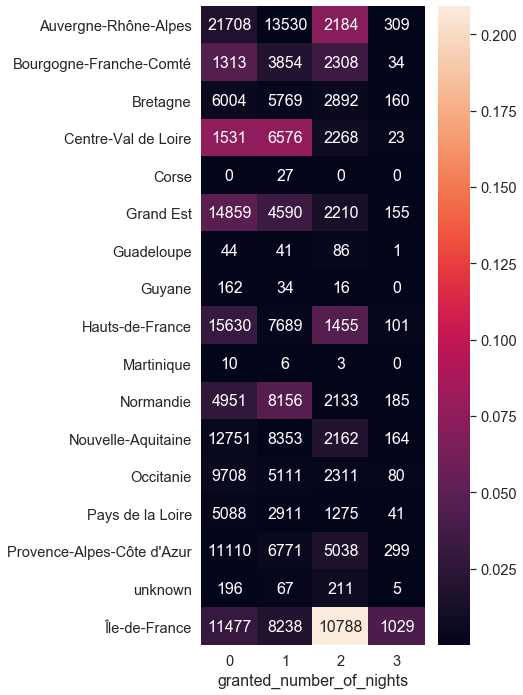

In [306]:
plot_cont(X="region",
    Y="granted_number_of_nights",
    data=requests_train)

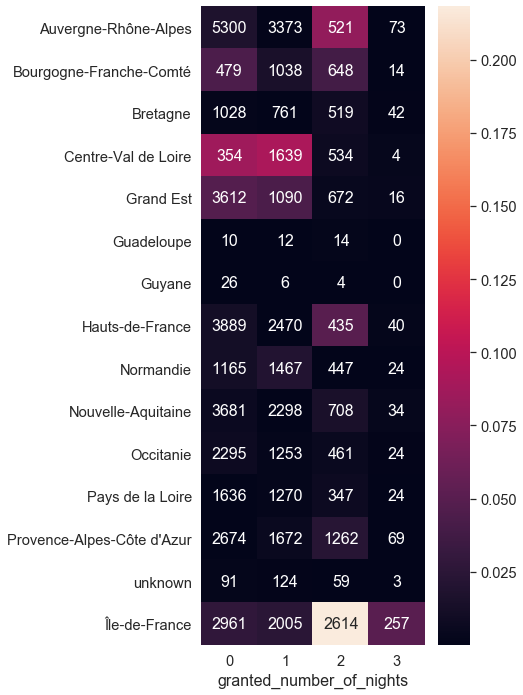

In [307]:
plot_cont(X="region",
    Y="granted_number_of_nights",
    data=requests_test)

=> OK : reduction of geolocalisation of request on regions area.

Information is still there because distribution  "granted_numer_of_nights" still depends of some regions 

### long_term_housing_request

In [308]:
requests_train["long_term_housing_request"].value_counts(dropna=False)

NaN    165556
f       60386
t       12249
Name: long_term_housing_request, dtype: int64

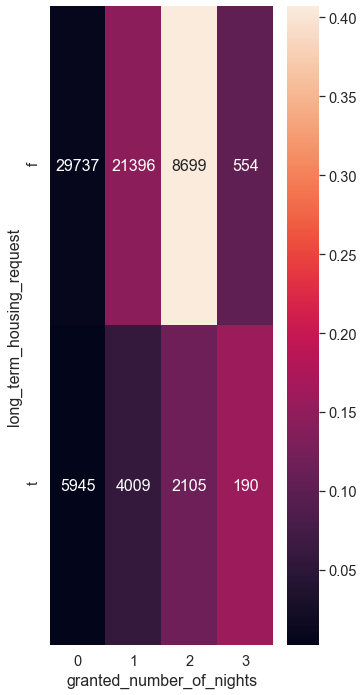

In [309]:
plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=requests_train)


We can try to replace NaN by 'f' (false) :

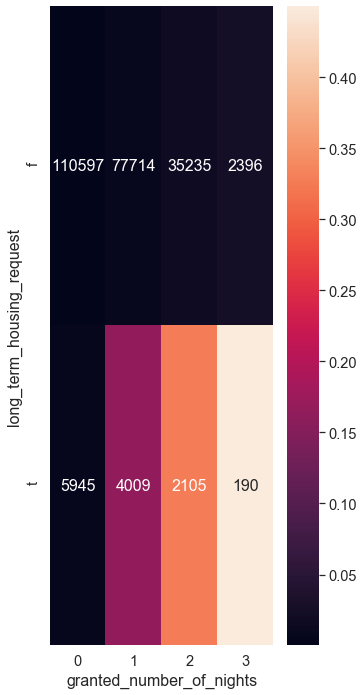

In [310]:
df_test = requests_train.copy()

df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'f'

plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=df_test)

=> NOK : Change too much initial information

So we keep unknown data : 

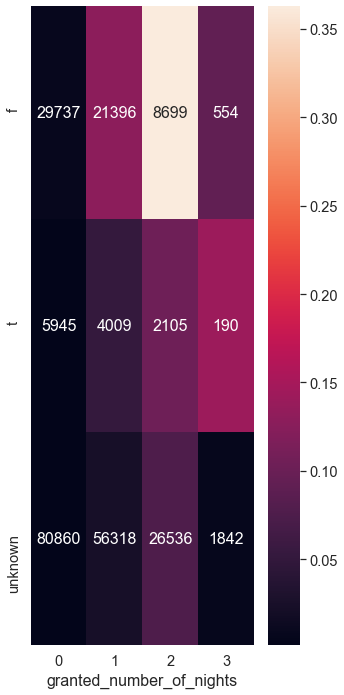

In [311]:
df_test = requests_train.copy()

df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'unknown'

plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=df_test)

In [546]:
requests_train[requests_train["granted_number_of_nights"] == 2].shape[0] / requests_train.shape[0]

0.15676494913745692

In [549]:
requests_train[requests_train["long_term_housing_request"] == 'f'].shape[0] * 0.1567

9462.486200000001

In [550]:
requests_train[requests_train["granted_number_of_nights"] == 3].shape[0] / requests_train.shape[0]

0.010856833381613916

In [551]:
requests_train[requests_train["long_term_housing_request"] == 'f'].shape[0] * 0.010856833381613916

655.6007405821379

In [552]:
requests_train[requests_train["granted_number_of_nights"] == 1].shape[0] / requests_train.shape[0]

0.34309860574077106

In [553]:
requests_train[requests_train["long_term_housing_request"] == 'f'].shape[0] * 0.34309860574077106

20718.352406262202

In [554]:
requests_train[requests_train["granted_number_of_nights"] == 0].shape[0] / requests_train.shape[0]

0.4892796117401581

In [555]:
requests_train[requests_train["long_term_housing_request"] == 'f'].shape[0] * 0.4892796117401581

29545.63863454119

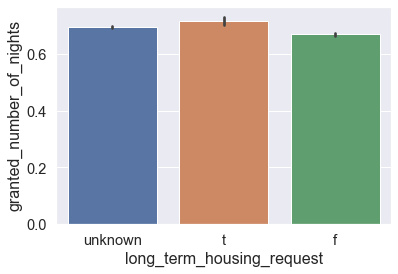

In [542]:
ax = sns.barplot(x="long_term_housing_request", y="granted_number_of_nights", 
                 data=requests_train)

In [316]:
requests_train.shape

(238191, 27)

In [312]:
requests_train = df_test.copy()

=> OK : information are kept

Doing the same for Test :

In [313]:
requests_test["long_term_housing_request"].value_counts(dropna=False)

NaN    41257
f      15244
t       3047
Name: long_term_housing_request, dtype: int64

In [314]:
df_test = requests_test.copy()
df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'unknown'
requests_test = df_test.copy()

In [315]:
requests_test.shape

(59548, 27)

=> OK we can use long_term_housing_request

### victim_of_violence_type

In [317]:
requests_train["victim_of_violence_type"].value_counts(dropna=False)

NaN                                  234175
woman                                  2177
woman victim of domestic violence      1278
man                                     326
family                                  162
man victim of domestic violence          43
child                                    30
Name: victim_of_violence_type, dtype: int64

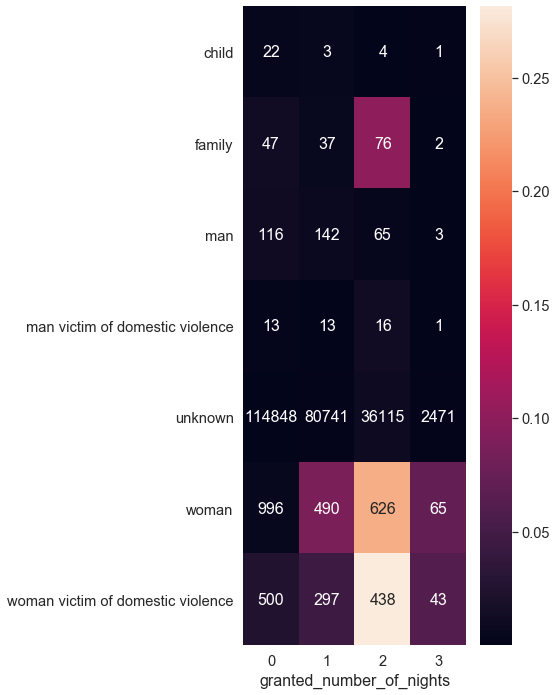

In [318]:
df_test = requests_train.copy()
df_test.loc[df_test["victim_of_violence_type"].isna(), \
    "victim_of_violence_type"] = 'unknown'

plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=df_test)

In [319]:
df_test.shape

(238191, 27)

In [320]:
requests_train.shape

(238191, 27)

In [321]:
requests_train = df_test.copy()

In [322]:
requests_train["victim_of_violence"].value_counts(dropna=False)

f    233881
t      4310
Name: victim_of_violence, dtype: int64

In [323]:
bol_unknown = requests_train["victim_of_violence_type"] != "unknown"

requests_train[bol_unknown]["victim_of_violence"].value_counts(dropna=False)

t    4016
Name: victim_of_violence, dtype: int64

To reduce dimension, We can add a label to category "victim_of_violence_type" : 'f' for no violence : 

In [324]:
bol_false = requests_train["victim_of_violence"] == 'f'
requests_train[bol_false]["victim_of_violence_type"].value_counts()

unknown    233881
Name: victim_of_violence_type, dtype: int64

In [325]:
requests_train.loc[bol_false, "victim_of_violence_type"] = "f"

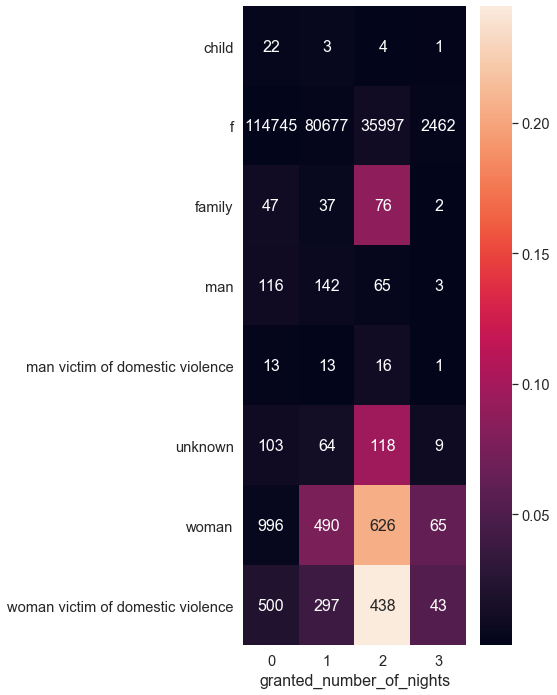

In [326]:
plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=requests_train)

In [327]:
df_test = requests_test.copy()
df_test.loc[df_test["victim_of_violence_type"].isna(), \
    "victim_of_violence_type"] = 'unknown'
requests_test = df_test.copy()

In [328]:
requests_test["victim_of_violence"].value_counts(dropna=False)

f      58501
t       1046
NaN        1
Name: victim_of_violence, dtype: int64

=> We correct only one data NaN : 

In [329]:
requests_test.loc[requests_test["victim_of_violence"].isna(), 
                 "victim_of_violence"] = 'f'

In [330]:
requests_test["victim_of_violence"].value_counts(dropna=False)

f    58502
t     1046
Name: victim_of_violence, dtype: int64

In [331]:
bol_unknown = requests_test["victim_of_violence_type"] != "unknown"

requests_test[bol_unknown]["victim_of_violence"].value_counts(dropna=False)

t    968
Name: victim_of_violence, dtype: int64

In [332]:
bol_false = requests_test["victim_of_violence"] == 'f'
requests_test[bol_false]["victim_of_violence_type"].value_counts()

unknown    58502
Name: victim_of_violence_type, dtype: int64

In [333]:
requests_test.loc[bol_false, "victim_of_violence_type"] = "f"

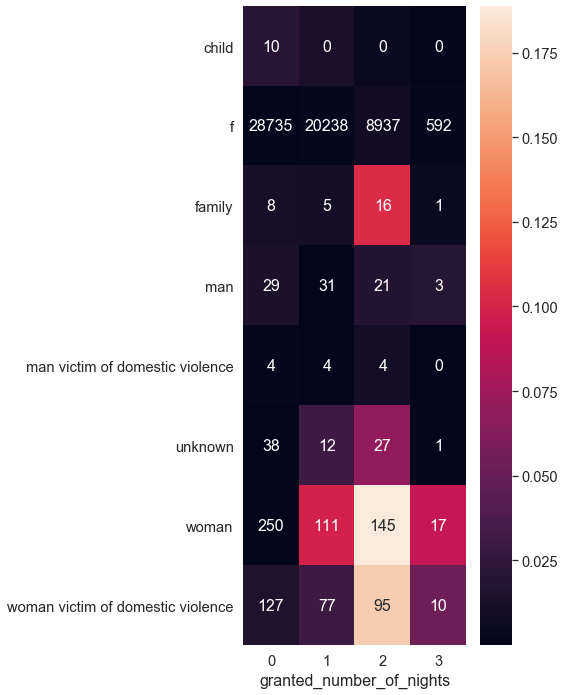

In [334]:
plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=requests_test)

=> OK because we will use "pregnancy" & "region" instead of "child_to_come" & "town"

### group_type & group_composition_label 

In [335]:
requests_train["group_type"].value_counts(dropna=False)

individual    171052
group          67139
Name: group_type, dtype: int64

In [336]:
requests_test["group_type"].value_counts(dropna=False)

individual    42830
group         16717
NaN               1
Name: group_type, dtype: int64

In [337]:
requests_test[requests_test["group_type"].isna()].T

53696
request_id                                 3cd662879be7dfd179e4bc1e8160039b
animal_presence                                                           f
answer_creation_date                                2019-01-15 11:02:32.677
child_situation                                                          -1
child_to_come                                                           NaN
district                                                                 87
granted_number_of_nights                                                  0
group_composition_id                                                     -1
group_composition_label                                                 NaN
group_creation_date                                                     NaN
group_id                                   86e5a6103ec0f0d686c6fd69aab18abf
group_main_requester_id                    6bb61e3b7bce0931da574d19d1d82c88
group_type                                                              NaN
housing_situation_id                                                    130
housing_situation_label                                     public hospital
long_term_housing_request                                           unknown
number_of_underage                                                       -1
request_backoffice_creator_id              b3a7758cf0adca037afde310cbe7d577
request_creation_date                               2019-01-15 11:02:32.677
requester_type                                                         user
social_situation_id                        6bb61e3b7bce0931da574d19d1d82c88
town                                                                    NaN
victim_of_violence                                                        f
victim_of_violence_type                                                   f
housing_situation_2_label      public instition (hospital, retirement home)
pregnancy                                                                 f
region                                                   Nouvelle-Aquitaine

=> NOK : correct nan value

We can replace:

In [338]:
req_id = \
    requests_test[requests_test["group_type"].isna()]["request_id"].values[0]

bol_req = individuals_test["request_id"] == req_id
individuals_test[bol_req].T

86308
request_id                                 3cd662879be7dfd179e4bc1e8160039b
individual_id                              e2e812f1e7c7850c87bf0f3255e8691a
housing_situation_2_id                                                   36
housing_situation_2_label      public instition (hospital, retirement home)
birth_month                                                              -1
birth_year                                                               -1
childcare_center_supervision                                            NaN
disabled_worker_certification                                           NaN
gender                                                                  NaN
individual_creation_date                                                NaN
individual_role                                                         NaN
individual_role_2_id                                                     -1
individual_role_2_label                                                 NaN
marital_status_id                                                        -1
marital_status_label                                                    NaN
pregnancy                                                               NaN

=> Only one people => "individual"

In [350]:
bol_nan = requests_test["group_type"].isna()

requests_test.at[bol_nan, 'group_type'] = "individual"

In [351]:
requests_test["group_type"].value_counts(dropna=False)

individual    42831
group         16717
Name: group_type, dtype: int64

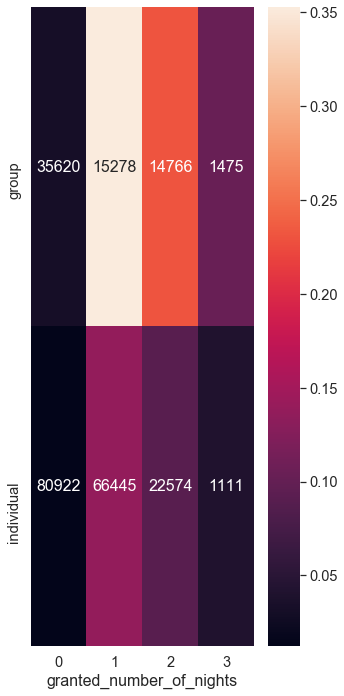

In [352]:
plot_cont(X="group_type",
    Y="granted_number_of_nights",
    data=requests_train)

#### group_composition_label

In [353]:
requests_train["group_composition_label"].value_counts(dropna=False)

man alone                        130492
woman alone                       36103
single mother with child(ren)     22336
couple with child(ren)            22057
couple without whildren            9525
group with child(ren)              6590
group of adults                    5096
isolated child/underage            3029
single father with child(ren)      1474
child/underage with family         1348
accompanied child/underage          115
women victim of violence             26
Name: group_composition_label, dtype: int64

In [354]:
requests_test["group_composition_label"].value_counts(dropna=False)

man alone                        32716
woman alone                       9028
single mother with child(ren)     5576
couple with child(ren)            5463
couple without whildren           2449
group with child(ren)             1560
group of adults                   1271
isolated child/underage            731
single father with child(ren)      379
child/underage with family         333
accompanied child/underage          31
women victim of violence            10
NaN                                  1
Name: group_composition_label, dtype: int64

=> NOK : one NaN value in Test : 
We can correct by "man alone" (the most represented label)

In [355]:
bol_nan = requests_test["group_composition_label"].isna()
requests_test.loc[bol_nan, 'group_composition_label'] = "man alone"

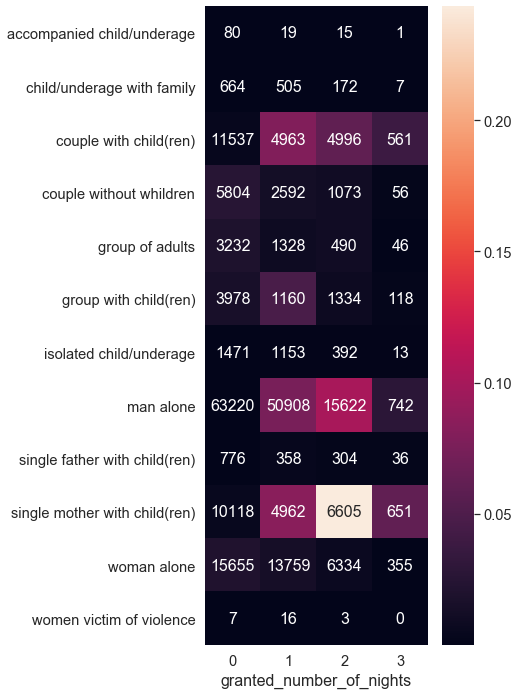

In [356]:
plot_cont(X="group_composition_label",
    Y="granted_number_of_nights",
    data=requests_train)

=> group_type can be a feature  but group_composition_label is more detailled.

We can take "group_composition_label" as feature

### number_of_underage

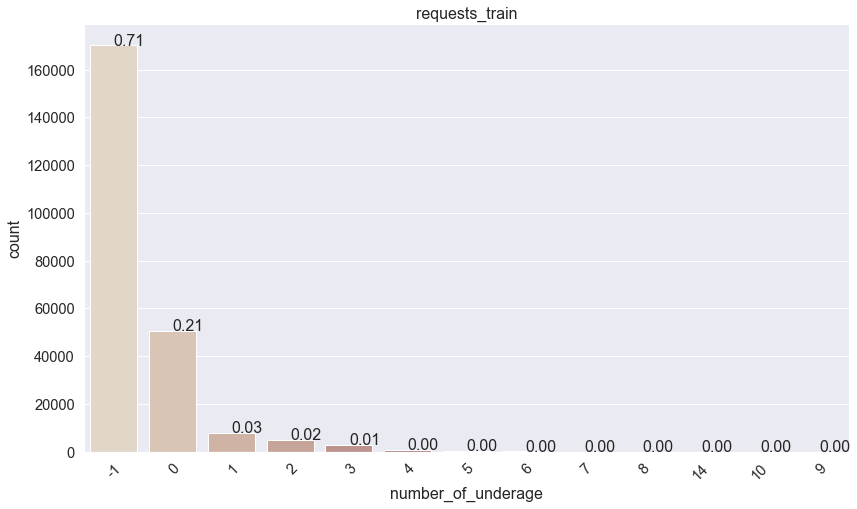

In [357]:
plot_hist_cat(x="number_of_underage", data=requests_train, 
              title="requests_train")

In [358]:
requests_train["number_of_underage"].value_counts()

-1     170220
 0      50725
 1       7915
 2       4967
 3       3014
 4        795
 5        381
 6         91
 7         70
 8          7
 14         2
 10         2
 9          2
Name: number_of_underage, dtype: int64

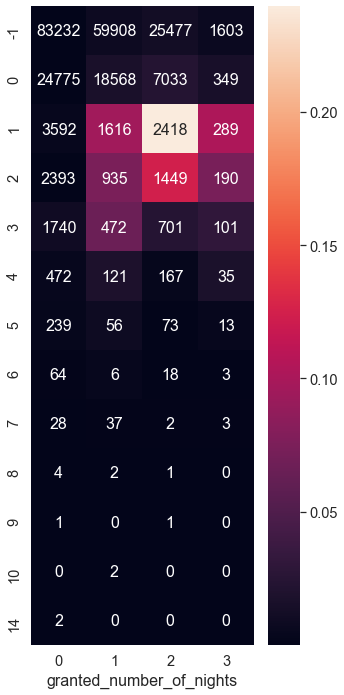

In [359]:
plot_cont(X="number_of_underage",
    Y="granted_number_of_nights",
    data=requests_train)

Try to reduce range of number_of_underage :

Max = 4 and min = 0 

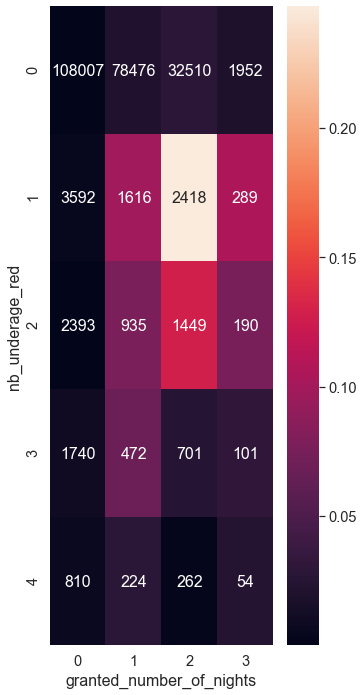

In [379]:
df_test = requests_train.copy()
df_test["nb_underage_red"] = df_test["number_of_underage"] 
bol_high = df_test["number_of_underage"] >= 4
df_test.loc[bol_high, "nb_underage_red"] = 4
bol_low = df_test["number_of_underage"] < 0
df_test.loc[bol_low, "nb_underage_red"] = 0
plot_cont(X="nb_underage_red",
    Y="granted_number_of_nights",
    data=df_test)

In [380]:
df_test.shape

(238191, 29)

In [381]:
requests_train.shape

(238191, 28)

In [556]:
requests_train.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   
disabled_worker_certification                                 f   
nb_female                                                     0   
nb_male                                                       1   
married                                                       f   
request_creation_date_fmt                   2019-02-11 22:30:00   
request_creation_day                                        Mon   
request_creation_day_num                                      1   
request_creation_month                                       02   
child_situation_red                                           0   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7

In [382]:
requests_train = df_test.copy()

Same for Test : 

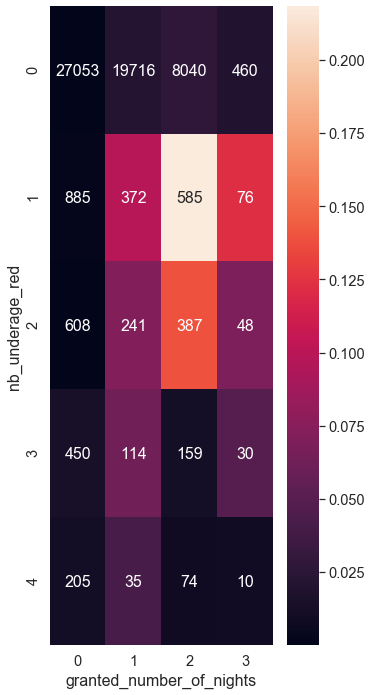

In [383]:
df_test = requests_test.copy()
df_test["nb_underage_red"] = df_test["number_of_underage"] 
bol_high = df_test["number_of_underage"] >= 4
df_test.loc[bol_high, "nb_underage_red"] = 4
bol_low = df_test["number_of_underage"] < 0
df_test.loc[bol_low, "nb_underage_red"] = 0
plot_cont(X="nb_underage_red",
    Y="granted_number_of_nights",
    data=df_test)

In [384]:
df_test.shape

(59548, 29)

In [385]:
requests_test.shape

(59548, 28)

In [386]:
requests_test = df_test.copy()

=> "nb_underage_red" can be used as feature

### childcare_center_supervision

In [387]:
individuals_train.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
individual_id                  b24a8cfaaf3663bac45ca3bcd24f0b36   
housing_situation_2_id                                       20   
housing_situation_2_label                         on the street   
birth_month                                                   5   
birth_year                                                 1977   
childcare_center_supervision                                NaN   
disabled_worker_certification                               NaN   
gender                                                     male   
individual_creation_date                             2018-01-29   
individual_role                                 isolated person   
individual_role_2_id                                         30   
individual_role_2_label                          isolated adult   
marital_status_id                                            10   
marital_status_label                              single person   
pregnancy                                                     f   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
individual_id                  eef783d1bda82661a751c12c34aff8c2   
housing_situation_2_id                                       20   
housing_situation_2_label                         on the street   
birth_month                                                   5   
birth_year                                                 1980   
childcare_center_supervision                                NaN   
disabled_worker_certification                               NaN   
gender                                                     male   
individual_creation_date                             2019-03-07   
individual_role                                             NaN   
individual_role_2_id                                         30   
individual_role_2_label                          isolated adult   
marital_status_id                                            -1   
marital_status_label                                        NaN   
pregnancy                                                     f   

                                                              2  \
request_id                     12cc0a18890bd4959fe42df3ae58838e   
individual_id                  927b6fa58d6be263c411332835b11fec   
housing_situation_2_id                                       20   
housing_situation_2_label                         on the street   
birth_month                                                   1   
birth_year                                                 2003   
childcare_center_supervision                                NaN   
disabled_worker_certification                               NaN   
gender                                                     male   
individual_creation_date                             2019-03-13   
individual_role                                             NaN   
individual_role_2_id                                         10   
individual_role_2_label                 isolated underage/child   
marital_status_id                                            -1   
marital_status_label                                        NaN   
pregnancy                                                     f   

                                                              3  \
request_id                     ae2d5b4dc181d29e430132f145da1556   
individual_id                  94181d5cf4a56cc84d12677df84e2e03   
housing_situation_2_id                                       20   
housing_situation_2_label                         on the street   
birth_month                                                   7   
birth_year                                                 1986   
childcare_center_supervision                                NaN   
disabled_worker_certification                               NaN   
gender                                 

In [388]:
individuals_train["childcare_center_supervision"].value_counts(dropna=False)

NaN    378254
f        3021
t        2858
Name: childcare_center_supervision, dtype: int64

In [389]:
individuals_train["individual_role_2_label"].value_counts(dropna=False)

isolated adult                160791
child/underage with family     95237
partner                        54544
husband/spouse                 25758
isolated parent                24180
other                           9268
family member                   8933
isolated underage/child         5367
NaN                               55
Name: individual_role_2_label, dtype: int64

In [390]:
bol_child_role = (individuals_train["individual_role_2_label"] \
    == "child/underage with family") | \
    (individuals_train["individual_role_2_label"] == "isolated underage/child")



individuals_train[bol_child_role]["childcare_center_supervision"] \
    .value_counts(dropna=False)

NaN    100552
t          38
f          14
Name: childcare_center_supervision, dtype: int64

In [391]:
individuals_train[individuals_train["childcare_center_supervision"] == \
                 't']["individual_role_2_label"] \
    .value_counts(dropna=False)

partner                       1093
isolated adult                1017
isolated parent                415
husband/spouse                 213
other                           73
child/underage with family      38
family member                    9
Name: individual_role_2_label, dtype: int64

We can detect if a individual in group is in childcare_center_supervision :

In [392]:
#pt_req individuals_train["childcare_center_supervision"]

def fun_find_one_true(serie_in):
    if ("t" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_cccs_train = pd.pivot_table(individuals_train, 
                              values='childcare_center_supervision', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_cccs_train

childcare_center_supervision
request_id                                                   
0000602749161524aedd04269957e5fc                            f
0000c66f6bb24e930cba6a3872d3ab02                            f
0000dbd253c096eab97cab0545915ab2                            f
0001826bdd626262ec2bda3a1b908aac                            f
0001925b4cd4d65110638ee3d5f2f454                            f
...                                                       ...
fffd7c7c22a9147bc4af4b869eb97f19                            f
fffeeac2155c826f0ccc2f912c1049f9                            f
fffeff160a0bf8c160c9e63436273cec                            f
ffff40d1408c4f032e1047adab9fbf93                            f
ffff8a617e122d989a9024a9c09fd622                            f

[238191 rows x 1 columns]

In [393]:
pt_req_cccs_train["childcare_center_supervision"].value_counts(dropna=False)

f    235333
t      2858
Name: childcare_center_supervision, dtype: int64

In [ ]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_cccs_train, on="request_id")

In [395]:
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   

                                        

In [396]:
df_test.shape

(238191, 29)

In [397]:
requests_train.shape

(238191, 29)

In [370]:
requests_train  = df_test.copy()

Same For Test : 

In [371]:
pt_req_cccs_test = pd.pivot_table(individuals_test, 
                              values='childcare_center_supervision', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_cccs_test

childcare_center_supervision
request_id                                                   
00025115a1823cf8dc4e405fac55aa08                            f
000329aa7e358635d26ff2d82a3f51d9                            f
00035ca76ed77fd146fbd433fdccd8a5                            f
0004db4b2bf9997bbd68d59c5c4d65a5                            f
00072464a3949529d9093a7622806527                            f
...                                                       ...
fffd6850c8daf68dcdf737647952f40d                            f
fffe858cbae1fcf6093a9676d81119d9                            f
fffec8a1dff845182d68e56ed8329a37                            f
ffff982c528b9dbd87da975d8a44c2bc                            f
ffffa1498a6f2bd46a2dbb5f76bcab43                            f

[59548 rows x 1 columns]

In [372]:
pt_req_cccs_test["childcare_center_supervision"].value_counts(dropna=False)

f    58878
t      670
Name: childcare_center_supervision, dtype: int64

In [373]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_cccs_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                          Hauts-de-France   
childcare_center_supervision                                  f   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                     Auvergne-Rhône-Alpes   
childcare_center_supervision                                  f   

                                                              2  \
request_id                     415696df2fef0b6a4d7e07b36d12dc7f   
animal_presence                         

In [374]:
requests_test.shape

(59548, 27)

In [375]:
df_test.shape

(59548, 28)

In [376]:
requests_test  = df_test.copy()

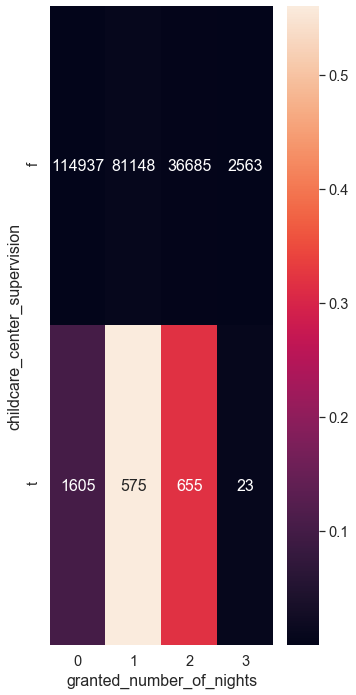

In [377]:
plot_cont(X="childcare_center_supervision",
    Y="granted_number_of_nights",
    data=requests_train)

=> childcare_center_supervision can be used as feature

### birth_year

mean or max or min ?

When have been done requests ?

In [400]:
requests_train["request_creation_date"].min()

'2019-01-01 00:42:43.371'

In [401]:
requests_train["request_creation_date"].max()

'2019-03-31 23:54:45.705'

In [402]:
requests_test["request_creation_date"].min()

'2019-01-01 01:56:03.424'

In [403]:
requests_test["request_creation_date"].max()

'2019-03-31 23:20:15.031'

=> in 2019

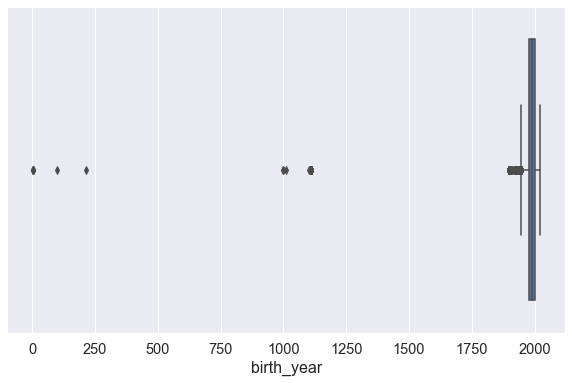

In [404]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_train, orient="h");

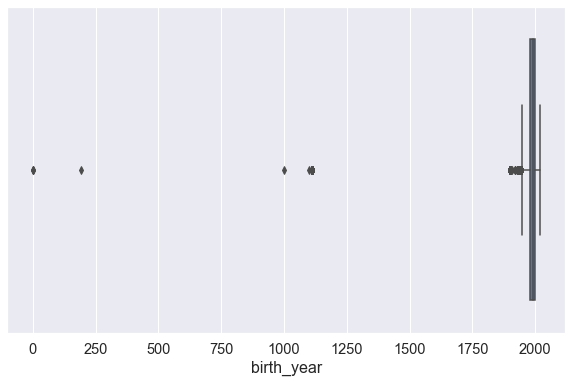

In [405]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_test, orient="h");

In [406]:
individuals_train[individuals_train["birth_year"] > 2019] \
    ["birth_year"].value_counts()

2021    1
Name: birth_year, dtype: int64

In [407]:
individuals_test[individuals_test["birth_year"] > 2019] \
    ["birth_year"].value_counts()

Series([], Name: birth_year, dtype: int64)

=> NOK : request are done in 2019. So max is 2019.

We correct by replacing with 2019

In [408]:
individuals_train.loc[individuals_train["birth_year"] > 2019, "birth_year"] = \
    2019
individuals_test.loc[individuals_test["birth_year"] > 2019, "birth_year"] = \
    2019

In [409]:
individuals_train[individuals_train["birth_year"] < 1901] \
    ["birth_year"].value_counts()

1900    2076
1111     191
1          6
1000       2
215        1
1100       1
1010       1
100        1
Name: birth_year, dtype: int64

In [410]:
individuals_test[individuals_test["birth_year"] < 1901] \
    ["birth_year"].value_counts()

 1900    556
 1111     48
 1         2
 1000      1
 190       1
 1098      1
-1         1
Name: birth_year, dtype: int64

=> NOK : we have to correct this data if we want to keep all samples

We choose to replace by mean value over all train samples

In [411]:
year_mean = np.round( \
individuals_train[individuals_train["birth_year"] >= 1901]["birth_year"].mean())
year_mean

1990.0

In [412]:
individuals_train.loc[individuals_train["birth_year"] < 1901, "birth_year"] = \
    year_mean
individuals_test.loc[individuals_test["birth_year"] < 1901, "birth_year"] = \
    year_mean

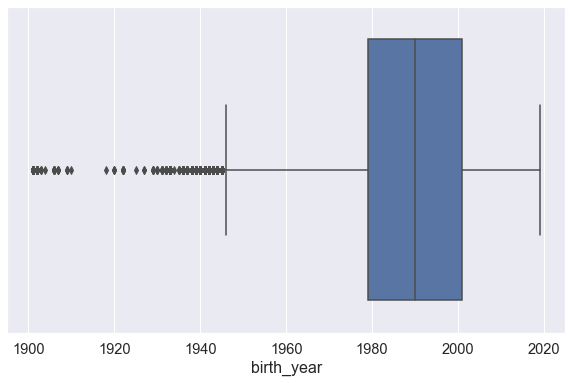

In [413]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_train, orient="h");

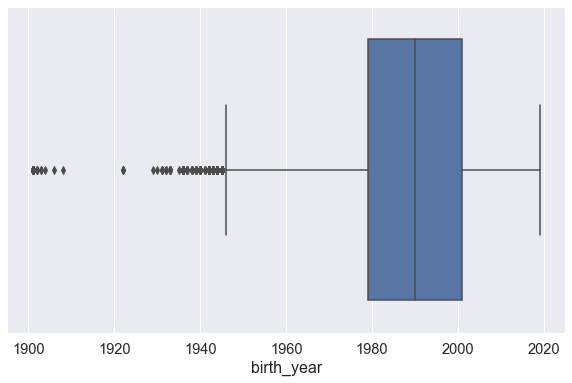

In [414]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_test, orient="h");

In [415]:
pt_req_year_train = pd.pivot_table(individuals_train, 
                              values='birth_year', 
               index=['request_id'], aggfunc=["min","max","mean"])
pt_req_year_train.columns = ["age_max", "age_min", "age_mean"]
pt_req_year_train = 2019 - pt_req_year_train
pt_req_year_train

age_max  age_min  age_mean
request_id                                                  
0000602749161524aedd04269957e5fc     23.0     23.0      23.0
0000c66f6bb24e930cba6a3872d3ab02     38.0     38.0      38.0
0000dbd253c096eab97cab0545915ab2     19.0     19.0      19.0
0001826bdd626262ec2bda3a1b908aac     39.0     39.0      39.0
0001925b4cd4d65110638ee3d5f2f454     26.0     26.0      26.0
...                                   ...      ...       ...
fffd7c7c22a9147bc4af4b869eb97f19     33.0     33.0      33.0
fffeeac2155c826f0ccc2f912c1049f9     42.0     42.0      42.0
fffeff160a0bf8c160c9e63436273cec     31.0     31.0      31.0
ffff40d1408c4f032e1047adab9fbf93     37.0     37.0      37.0
ffff8a617e122d989a9024a9c09fd622     51.0     51.0      51.0

[238191 rows x 3 columns]

In [416]:
pt_req_year_train.describe()

age_max        age_min       age_mean
count  238191.000000  238191.000000  238191.000000
mean       36.609439      29.157021      32.691396
std        12.548452      17.214400      13.612519
min         0.000000       0.000000       0.000000
25%        27.000000      19.000000      22.000000
50%        35.000000      29.000000      29.750000
75%        44.000000      41.000000      41.000000
max       118.000000     118.000000     118.000000

In [417]:
pt_req_year_test = pd.pivot_table(individuals_test, 
                              values='birth_year', 
               index=['request_id'], aggfunc=["min","max","mean"])
pt_req_year_test.columns = ["age_max", "age_min", "age_mean"]
pt_req_year_test = 2019 - pt_req_year_test
pt_req_year_test

age_max  age_min   age_mean
request_id                                                   
00025115a1823cf8dc4e405fac55aa08     48.0      4.0  24.666667
000329aa7e358635d26ff2d82a3f51d9     27.0      3.0  15.750000
00035ca76ed77fd146fbd433fdccd8a5     20.0     20.0  20.000000
0004db4b2bf9997bbd68d59c5c4d65a5     33.0      1.0  17.000000
00072464a3949529d9093a7622806527     25.0     25.0  25.000000
...                                   ...      ...        ...
fffd6850c8daf68dcdf737647952f40d     45.0     45.0  45.000000
fffe858cbae1fcf6093a9676d81119d9     27.0      0.0  13.500000
fffec8a1dff845182d68e56ed8329a37     58.0     58.0  58.000000
ffff982c528b9dbd87da975d8a44c2bc     22.0     22.0  22.000000
ffffa1498a6f2bd46a2dbb5f76bcab43     33.0     33.0  33.000000

[59548 rows x 3 columns]

In [418]:
pt_req_year_test.describe()

age_max       age_min      age_mean
count  59548.000000  59548.000000  59548.000000
mean      36.566333     29.173826     32.670515
std       12.479526     17.114133     13.535322
min        0.000000      0.000000      0.000000
25%       27.000000     19.000000     22.000000
50%       35.000000     29.000000     30.000000
75%       44.000000     40.000000     41.000000
max      118.000000    118.000000    118.000000

In [419]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_year_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Prov

In [420]:
requests_train.shape

(238191, 29)

In [421]:
df_test.shape

(238191, 32)

In [422]:
requests_train = df_test.copy()

Same for Test :

In [423]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_year_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                          Hauts-de-France   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      41   
age_min                                                      10   
age_mean                                                   25.5   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                   

In [424]:
df_test.shape

(59548, 32)

In [425]:
requests_test.shape

(59548, 29)

In [426]:
requests_test = df_test.copy()

We can see some dependencies on number of nights : 

(-1, 80)

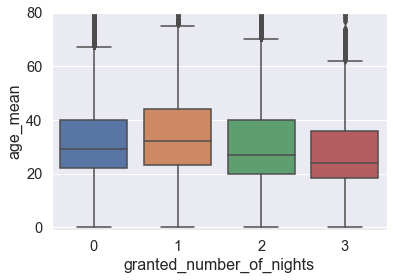

In [427]:
ax = sns.boxplot(x="granted_number_of_nights", y="age_mean", 
                 data=requests_train)
ax.set_ylim([-1,80])

(-1, 91)

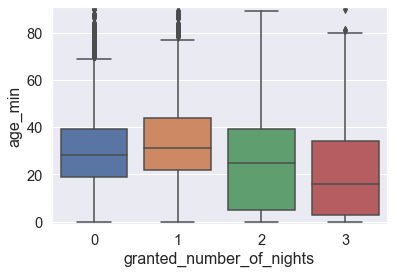

In [428]:
ax = sns.boxplot(x="granted_number_of_nights", y="age_min", 
                 data=requests_train)
ax.set_ylim([-1, 91])

(-1, 80)

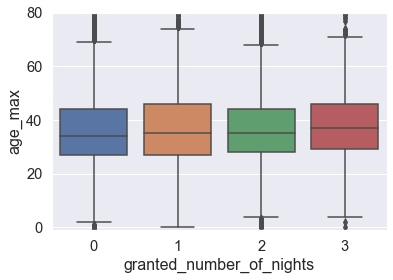

In [429]:
ax = sns.boxplot(x="granted_number_of_nights", y="age_max", 
                 data=requests_train)
ax.set_ylim([-1, 80])

=> OK, we can use "age_x" as features.

### disabled_worker_certification

In [430]:
individuals_train["disabled_worker_certification"].value_counts(dropna=False)

NaN    254741
f      126270
t        3122
Name: disabled_worker_certification, dtype: int64

In [431]:
bol_nan = individuals_train["disabled_worker_certification"].isna()

individuals_train.loc[bol_nan, "disabled_worker_certification"] = 'f'

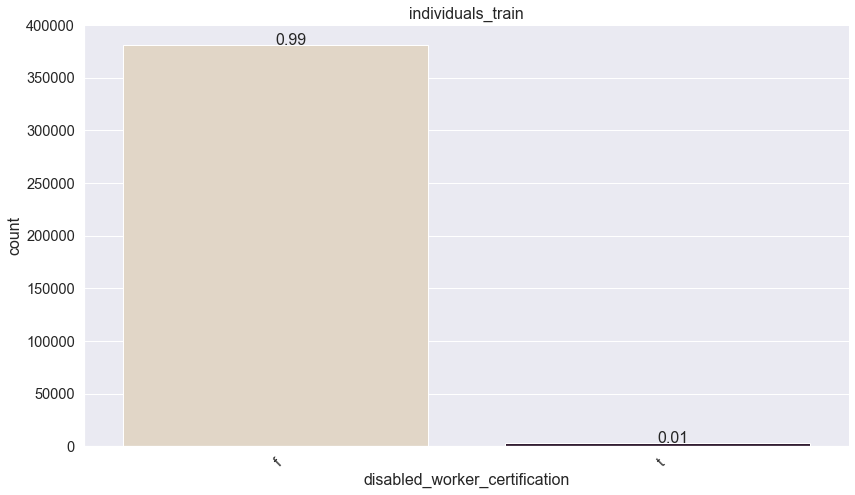

In [432]:
plot_hist_cat(x="disabled_worker_certification", data=individuals_train, 
              title="individuals_train")

Check NaN values ? 

In [433]:
individuals_test["disabled_worker_certification"].value_counts(dropna=False)

NaN    62986
f      31860
t        795
Name: disabled_worker_certification, dtype: int64

=> NOK : We correct NaN by false

In [434]:
bol_nan = individuals_test["disabled_worker_certification"].isna()

individuals_test.loc[bol_nan, "disabled_worker_certification"] = 'f'

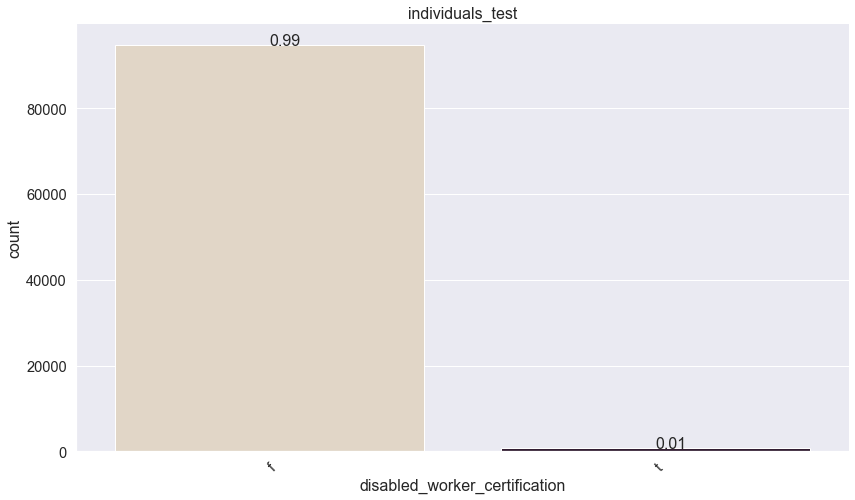

In [435]:
plot_hist_cat(x="disabled_worker_certification", data=individuals_test, 
              title="individuals_test")

In [436]:
pt_req_dwc_train = pd.pivot_table(individuals_train, 
                              values='disabled_worker_certification', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_dwc_train

disabled_worker_certification
request_id                                                    
0000602749161524aedd04269957e5fc                             f
0000c66f6bb24e930cba6a3872d3ab02                             f
0000dbd253c096eab97cab0545915ab2                             f
0001826bdd626262ec2bda3a1b908aac                             f
0001925b4cd4d65110638ee3d5f2f454                             f
...                                                        ...
fffd7c7c22a9147bc4af4b869eb97f19                             f
fffeeac2155c826f0ccc2f912c1049f9                             f
fffeff160a0bf8c160c9e63436273cec                             f
ffff40d1408c4f032e1047adab9fbf93                             f
ffff8a617e122d989a9024a9c09fd622                             f

[238191 rows x 1 columns]

In [437]:
pt_req_dwc_train["disabled_worker_certification"].value_counts()

f    235085
t      3106
Name: disabled_worker_certification, dtype: int64

In [438]:
pt_req_dwc_test = pd.pivot_table(individuals_test, 
                              values='disabled_worker_certification', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_dwc_test

disabled_worker_certification
request_id                                                    
00025115a1823cf8dc4e405fac55aa08                             f
000329aa7e358635d26ff2d82a3f51d9                             f
00035ca76ed77fd146fbd433fdccd8a5                             f
0004db4b2bf9997bbd68d59c5c4d65a5                             f
00072464a3949529d9093a7622806527                             f
...                                                        ...
fffd6850c8daf68dcdf737647952f40d                             f
fffe858cbae1fcf6093a9676d81119d9                             f
fffec8a1dff845182d68e56ed8329a37                             f
ffff982c528b9dbd87da975d8a44c2bc                             f
ffffa1498a6f2bd46a2dbb5f76bcab43                             f

[59548 rows x 1 columns]

In [439]:
pt_req_dwc_test["disabled_worker_certification"].value_counts()

f    58757
t      791
Name: disabled_worker_certification, dtype: int64

In [440]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_dwc_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   
disabled_worker_certification                                 f   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                

In [441]:
requests_train.shape

(238191, 32)

In [442]:
df_test.shape

(238191, 33)

In [443]:
requests_train = df_test.copy()

Same for Test :

In [444]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_dwc_test, on="request_id")

In [445]:
df_test.shape

(59548, 33)

In [446]:
requests_test.shape

(59548, 32)

In [447]:
requests_test = df_test.copy()

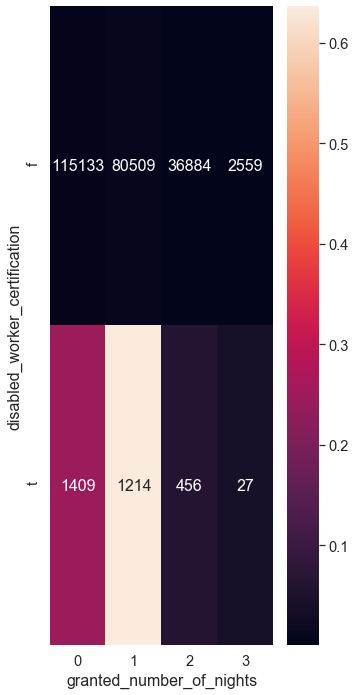

In [448]:
plot_cont(X="disabled_worker_certification",
    Y="granted_number_of_nights",
    data=requests_train)

=> OK . We can use "disabled_worker_certification" as feature

### gender 	

In [449]:
individuals_train["gender"].value_counts(dropna=False)

male      233146
female    150986
NaN            1
Name: gender, dtype: int64

In [450]:
bol_nan = individuals_train["gender"].isna()
individuals_train[bol_nan]

request_id                     individual_id  \
180905  114bf921f5e0212b983dd7ce11829a59  e4e621b67e5e54813635f8cbdc7765c0   

        housing_situation_2_id housing_situation_2_label  birth_month  \
180905                      20             on the street           10   

        birth_year childcare_center_supervision disabled_worker_certification  \
180905      1966.0                          NaN                             f   

       gender individual_creation_date individual_role  individual_role_2_id  \
180905    NaN               2018-11-01             NaN                    30   

       individual_role_2_label  marital_status_id marital_status_label  \
180905          isolated adult                 10        single person   

       pregnancy  
180905         f

In [451]:
req_id = individuals_train[bol_nan]["request_id"].values[0]
requests_train[requests_train["request_id"] == req_id] \
    ["group_composition_label"]

112163    man alone
Name: group_composition_label, dtype: object

=> gender = male

In [452]:
individuals_train[bol_nan] = "male"

In [453]:
individuals_train["gender"].value_counts(dropna=False)

male      233147
female    150986
Name: gender, dtype: int64

In [454]:
individuals_test["gender"].value_counts(dropna=False)

male      58135
female    37505
NaN           1
Name: gender, dtype: int64

In [455]:
bol_nan = individuals_test["gender"].isna()
individuals_test[bol_nan]

request_id                     individual_id  \
86308  3cd662879be7dfd179e4bc1e8160039b  e2e812f1e7c7850c87bf0f3255e8691a   

       housing_situation_2_id                     housing_situation_2_label  \
86308                      36  public instition (hospital, retirement home)   

       birth_month  birth_year childcare_center_supervision  \
86308           -1      1990.0                          NaN   

      disabled_worker_certification gender individual_creation_date  \
86308                             f    NaN                      NaN   

      individual_role  individual_role_2_id individual_role_2_label  \
86308             NaN                    -1                     NaN   

       marital_status_id marital_status_label pregnancy  
86308                 -1                  NaN       NaN

In [456]:
req_id = individuals_test[bol_nan]["request_id"].values[0]
requests_test[requests_test["request_id"] == req_id] \
    ["group_composition_label"]

53696    man alone
Name: group_composition_label, dtype: object

=> gender = male

In [457]:
individuals_test[bol_nan] = "male"

In [458]:
individuals_test["gender"].value_counts(dropna=False)

male      58136
female    37505
Name: gender, dtype: int64

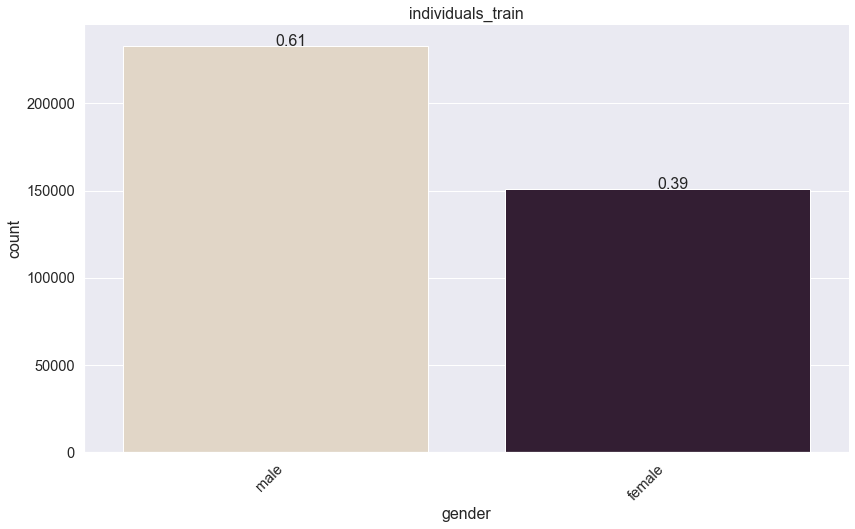

In [459]:
plot_hist_cat(x="gender", data=individuals_train, 
              title="individuals_train")

In [460]:
def fun_find_nb_gender(serie_in, gender):
    return serie_in.tolist().count(gender)
    
def fun_find_nb_male(serie_in):
    return fun_find_nb_gender(serie_in, "male")
def fun_find_nb_female(serie_in):
    return fun_find_nb_gender(serie_in, "female")

pt_req_g_train = pd.pivot_table(individuals_train, 
                              values='gender', 
               index=['request_id'], aggfunc=[fun_find_nb_female,
                                              fun_find_nb_male])

pt_req_g_train.columns = ["nb_female", "nb_male"]
pt_req_g_train

nb_female  nb_male
request_id                                          
0000602749161524aedd04269957e5fc          0        1
0000c66f6bb24e930cba6a3872d3ab02          0        1
0000dbd253c096eab97cab0545915ab2          1        0
0001826bdd626262ec2bda3a1b908aac          1        0
0001925b4cd4d65110638ee3d5f2f454          0        1
...                                     ...      ...
fffeeac2155c826f0ccc2f912c1049f9          0        1
fffeff160a0bf8c160c9e63436273cec          0        1
ffff40d1408c4f032e1047adab9fbf93          1        0
ffff8a617e122d989a9024a9c09fd622          1        0
male                                      0        1

[238191 rows x 2 columns]

In [461]:
pt_req_g_train.describe()

nb_female        nb_male
count  238191.000000  238191.000000
mean        0.633886       0.978824
std         0.890447       0.711009
min         0.000000       0.000000
25%         0.000000       1.000000
50%         0.000000       1.000000
75%         1.000000       1.000000
max         8.000000       8.000000

In [462]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_g_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   
disabled_worker_certification                                 f   
nb_female                                                     0   
nb_male                                                       1   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                  

In [463]:
requests_train.shape

(238191, 33)

In [464]:
df_test.shape

(238191, 35)

In [465]:
requests_train = df_test.copy()

Same for Test :

In [466]:
pt_req_g_test = pd.pivot_table(individuals_test, 
                              values='gender', 
               index=['request_id'], aggfunc=[fun_find_nb_female,
                                              fun_find_nb_male])

pt_req_g_test.columns = ["nb_female", "nb_male"]
pt_req_g_test

nb_female  nb_male
request_id                                          
00025115a1823cf8dc4e405fac55aa08          2        1
000329aa7e358635d26ff2d82a3f51d9          3        1
00035ca76ed77fd146fbd433fdccd8a5          1        0
0004db4b2bf9997bbd68d59c5c4d65a5          2        0
00072464a3949529d9093a7622806527          1        0
...                                     ...      ...
fffe858cbae1fcf6093a9676d81119d9          3        1
fffec8a1dff845182d68e56ed8329a37          1        0
ffff982c528b9dbd87da975d8a44c2bc          0        1
ffffa1498a6f2bd46a2dbb5f76bcab43          0        1
male                                      0        1

[59548 rows x 2 columns]

In [467]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_g_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                          Hauts-de-France   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      41   
age_min                                                      10   
age_mean                                                   25.5   
disabled_worker_certification                                 f   
nb_female                                                     1   
nb_male                                                       1   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                  

In [468]:
requests_test.shape

(59548, 33)

In [469]:
df_test.shape

(59548, 35)

In [470]:
requests_test = df_test.copy()

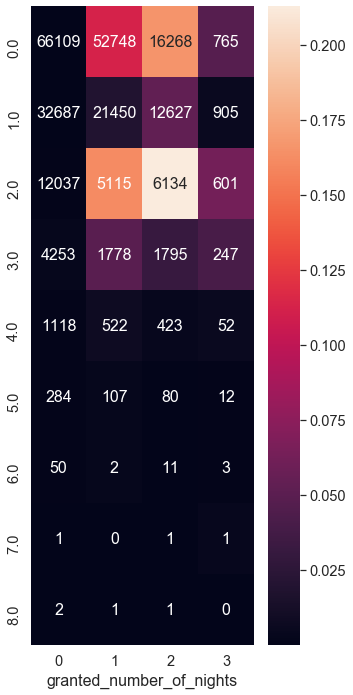

In [471]:
plot_cont(X="nb_female",
    Y="granted_number_of_nights",
    data=requests_train)

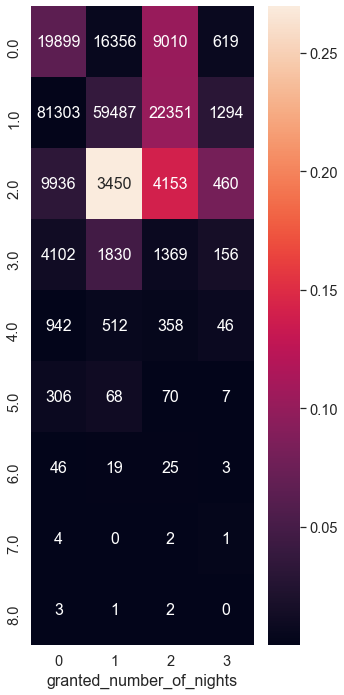

In [472]:
plot_cont(X="nb_male",
    Y="granted_number_of_nights",
    data=requests_train)

We can reduce range up to 4 people:

In [476]:
requests_train.loc[requests_train["nb_male"]>4, "nb_male"] = 4

In [477]:
requests_train.loc[requests_train["nb_female"]>4, "nb_female"] = 4

Check if Nan values

In [562]:
requests_train[requests_train["nb_male"].isna()]

Empty DataFrame
Columns: [request_id, animal_presence, answer_creation_date, child_situation, child_to_come, district, granted_number_of_nights, group_composition_id, group_composition_label, group_creation_date, group_id, group_main_requester_id, group_type, housing_situation_id, housing_situation_label, long_term_housing_request, number_of_underage, request_backoffice_creator_id, request_creation_date, requester_type, social_situation_id, town, victim_of_violence, victim_of_violence_type, housing_situation_2_label, pregnancy, region, childcare_center_supervision, nb_underage_red, age_max, age_min, age_mean, disabled_worker_certification, nb_female, nb_male, married, request_creation_date_fmt, request_creation_day, request_creation_day_num, request_creation_month, child_situation_red]
Index: []

[0 rows x 41 columns]

In [566]:
requests_test[requests_test["nb_female"].isna()]

Empty DataFrame
Columns: [request_id, animal_presence, answer_creation_date, child_situation, child_to_come, district, granted_number_of_nights, group_composition_id, group_composition_label, group_creation_date, group_id, group_main_requester_id, group_type, housing_situation_id, housing_situation_label, long_term_housing_request, number_of_underage, request_backoffice_creator_id, request_creation_date, requester_type, social_situation_id, town, victim_of_violence, victim_of_violence_type, housing_situation_2_label, pregnancy, region, childcare_center_supervision, nb_underage_red, age_max, age_min, age_mean, disabled_worker_certification, nb_female, nb_male, married, request_creation_date_fmt, request_creation_day, request_creation_day_num, request_creation_month, child_situation_red]
Index: []

[0 rows x 41 columns]

Correct NaN values

In [565]:
requests_train.at[requests_train["nb_male"].isna(), "nb_male"] = 1
requests_train.at[requests_train["nb_female"].isna(), "nb_female"] = 0
requests_test.at[requests_test["nb_male"].isna(), "nb_male"] = 1
requests_test.at[requests_test["nb_female"].isna(), "nb_female"] = 0

=> OK, we can use "nb_female" & "nb_male" as features

### marital_status_label & individual_role_2_label

In [478]:
individuals_train["marital_status_label"].value_counts(dropna=False)

single person           201443
NaN                     102338
married                  39961
cohabitation             31098
separated                 3580
marital relationship      2879
divorced                  2013
widowed                    652
civil partner              168
male                         1
Name: marital_status_label, dtype: int64

In [479]:
individuals_test["marital_status_label"].value_counts(dropna=False)

single person           50597
NaN                     24871
married                 10251
cohabitation             7675
separated                 850
marital relationship      678
divorced                  491
widowed                   178
civil partner              49
male                        1
Name: marital_status_label, dtype: int64

=> NOK : Too many NaN values.

Maybe we can use another data individual_role or individual_role_2_label

In [480]:
bol_nan = individuals_train["marital_status_label"].isna()
individuals_train[bol_nan]["individual_role"].value_counts()

child              8778
isolated person    7133
husband/spouse     1862
isolated parent    1599
partner            1317
family member        75
other                19
Name: individual_role, dtype: int64

In [481]:
individuals_train[bol_nan]["individual_role_2_label"].value_counts()

isolated adult                40885
child/underage with family    36968
partner                        9745
isolated parent                5245
other                          3091
family member                  3042
isolated underage/child        1731
husband/spouse                 1576
Name: individual_role_2_label, dtype: int64

In [482]:
bol_check = individuals_train["individual_role_2_label"] == "partner"
individuals_train[bol_check]["marital_status_label"].value_counts()

cohabitation            26549
married                 13599
single person            2239
marital relationship     2144
divorced                  147
separated                  91
civil partner              29
widowed                     1
Name: marital_status_label, dtype: int64

=> We cannot use marital_status_label because too much mixed with role.

We can just try to know if in the group, the couple is married.
Because we have got a group type feature yet.

In [484]:
individuals_train["individual_role_2_label"].value_counts(dropna=False)

isolated adult                160790
child/underage with family     95237
partner                        54544
husband/spouse                 25758
isolated parent                24180
other                           9268
family member                   8933
isolated underage/child         5367
NaN                               55
male                               1
Name: individual_role_2_label, dtype: int64

=> NOK : some NaN values can be corrected  :

In [485]:
bol_nan = individuals_train["individual_role_2_label"].isna()
individuals_train[bol_nan]["individual_role"].value_counts(dropna=False)

child              18
isolated person    14
husband/spouse     10
partner             7
isolated parent     5
family member       1
Name: individual_role, dtype: int64

In [486]:
bol_marr = individuals_train["individual_role"] == "husband/spouse"
individuals_train.loc[bol_nan & bol_marr, "individual_role_2_label"] = \
    "husband/spouse"

In [487]:
individuals_test["individual_role_2_label"].value_counts(dropna=False)

isolated adult                40139
child/underage with family    23517
partner                       13516
husband/spouse                 6545
isolated parent                5980
other                          2359
family member                  2198
isolated underage/child        1374
NaN                              12
male                              1
Name: individual_role_2_label, dtype: int64

In [488]:
bol_nan = individuals_test["individual_role_2_label"].isna()
individuals_test[bol_nan]["individual_role"].value_counts(dropna=False)

child              7
partner            3
isolated person    2
Name: individual_role, dtype: int64

=> NOK : no values can be corrected but number = 12 only 

We can detect if in the group, we have a married couple : individual_role_2_label == "husband/spouse"

In [489]:
def fun_find_marr(serie_in):
    if ("husband/spouse" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_marr_train = pd.pivot_table(individuals_train, 
                              values='individual_role_2_label', 
               index=['request_id'], aggfunc=fun_find_marr)

pt_req_marr_train.columns = ["married"]
pt_req_marr_train

married
request_id                              
0000602749161524aedd04269957e5fc       f
0000c66f6bb24e930cba6a3872d3ab02       f
0000dbd253c096eab97cab0545915ab2       f
0001826bdd626262ec2bda3a1b908aac       f
0001925b4cd4d65110638ee3d5f2f454       f
...                                  ...
fffeeac2155c826f0ccc2f912c1049f9       f
fffeff160a0bf8c160c9e63436273cec       f
ffff40d1408c4f032e1047adab9fbf93       f
ffff8a617e122d989a9024a9c09fd622       f
male                                   f

[238191 rows x 1 columns]

In [490]:
pt_req_marr_train["married"].value_counts()

f    223289
t     14902
Name: married, dtype: int64

In [491]:
pt_req_marr_test = pd.pivot_table(individuals_test, 
                              values='individual_role_2_label', 
               index=['request_id'], aggfunc=fun_find_marr)

pt_req_marr_test.columns = ["married"]
pt_req_marr_test

married
request_id                              
00025115a1823cf8dc4e405fac55aa08       f
000329aa7e358635d26ff2d82a3f51d9       t
00035ca76ed77fd146fbd433fdccd8a5       f
0004db4b2bf9997bbd68d59c5c4d65a5       f
00072464a3949529d9093a7622806527       f
...                                  ...
fffe858cbae1fcf6093a9676d81119d9       f
fffec8a1dff845182d68e56ed8329a37       f
ffff982c528b9dbd87da975d8a44c2bc       f
ffffa1498a6f2bd46a2dbb5f76bcab43       f
male                                   f

[59548 rows x 1 columns]

In [492]:
pt_req_marr_test["married"].value_counts()

f    55750
t     3798
Name: married, dtype: int64

In [493]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_marr_train, on="request_id")
df_test.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   
disabled_worker_certification                                 f   
nb_female                                                     0   
nb_male                                                       1   
married                                                       f   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-12 09:00:00   
requester_type                                             user   
social_situation_id            11f64f0547e855c5c59329b9edc63063   
town                                                        NaN   
victim_of_violence                       

In [494]:
requests_train.shape

(238191, 35)

In [495]:
df_test.shape

(238191, 36)

In [496]:
requests_train = df_test.copy()

In [497]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_marr_test, on="request_id")
df_test.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                          Hauts-de-France   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      41   
age_min                                                      10   
age_mean                                                   25.5   
disabled_worker_certification                                 f   
nb_female                                                     1   
nb_male                                                       1   
married                                                       f   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2019-02-27 15:06:56.757   
requester_type                                             user   
social_situation_id            358a2da195c1bb0b906d2e5c4213bdc1   
town                                                        NaN   
victim_of_violence                       

In [498]:
requests_test.shape

(59548, 35)

In [499]:
df_test.shape

(59548, 36)

In [500]:
requests_test = df_test.copy()

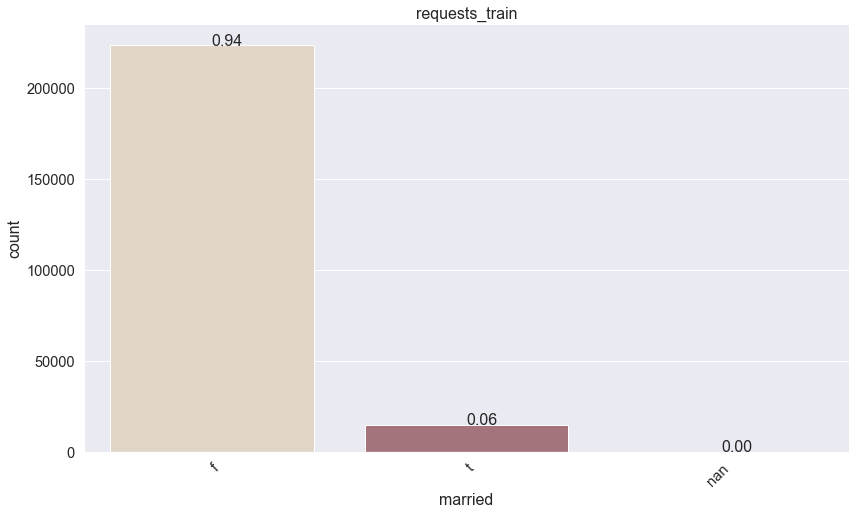

In [501]:
plot_hist_cat(x="married", data=requests_train, 
              title="requests_train")

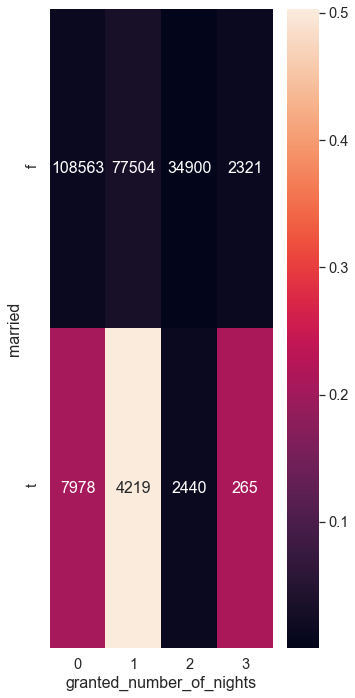

In [502]:
plot_cont(X="married",
    Y="granted_number_of_nights",
    data=requests_train)

=> We can use married data as feature

### requester_type

In [503]:
requests_train["requester_type"].value_counts(dropna=False)

user             234773
third party        3159
social patrol       259
Name: requester_type, dtype: int64

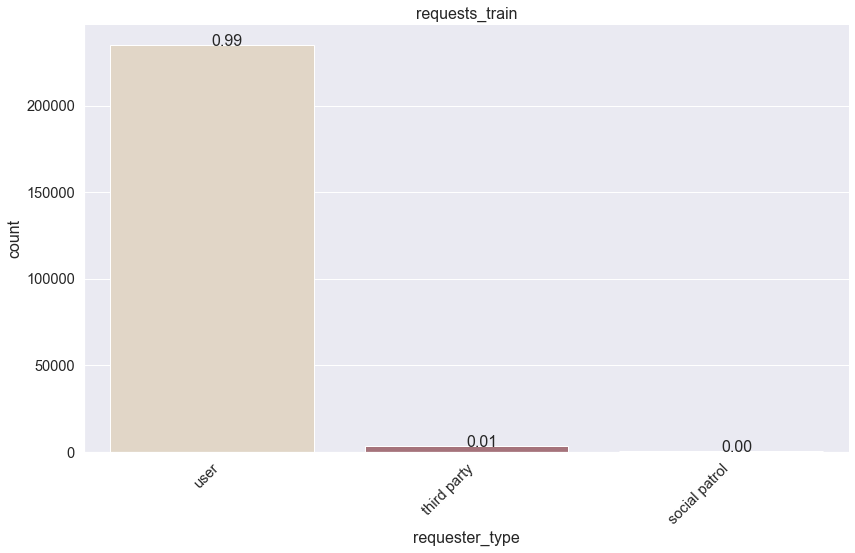

In [504]:
plot_hist_cat(x="requester_type", data=requests_train, 
              title="requests_train")

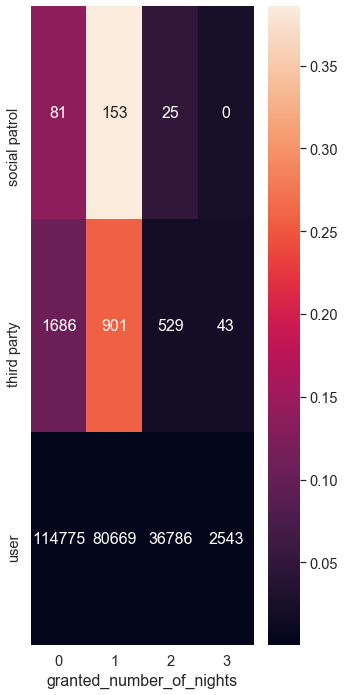

In [505]:
plot_cont(X="requester_type", Y="granted_number_of_nights", data=requests_train)

=> OK Dependency of distribution : We can maybe use 2 labels of request type : third party & social patrol because user représente 99% of request. 

### animal_presence 	

In [506]:
requests_train["animal_presence"].value_counts(dropna=False)

f    237528
t       663
Name: animal_presence, dtype: int64

In [507]:
requests_test["animal_presence"].value_counts(dropna=False)

f    59380
t      168
Name: animal_presence, dtype: int64

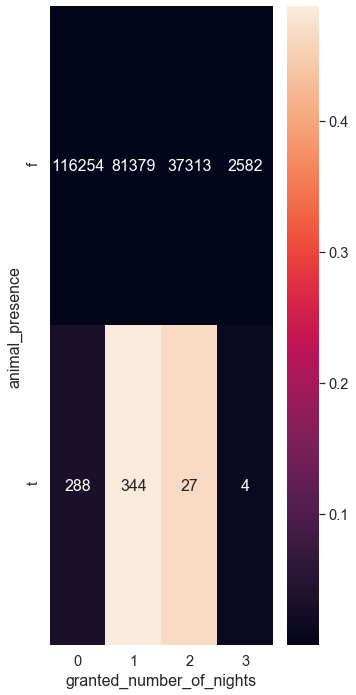

In [508]:
plot_cont(X="animal_presence", Y="granted_number_of_nights", 
          data=requests_train)

=> OK : We can use "animal_presence" as feature

### request_creation_date & answer_creation_date 	

We can try to extract day of week and month & answer delay ?

In [509]:
requests_train["request_creation_date"].min()

'2019-01-01 00:42:43.371'

In [510]:
requests_train["request_creation_date"].max()

'2019-03-31 23:54:45.705'

In [511]:
requests_test["request_creation_date"].min()

'2019-01-01 01:56:03.424'

In [512]:
requests_test["request_creation_date"].max()

'2019-03-31 23:20:15.031'

In [513]:
requests_test["request_creation_date"].sample(10)

12887    2019-02-01 10:49:59.589
28918    2019-03-28 09:36:44.418
20878    2019-03-22 10:52:02.234
18403    2019-02-08 10:08:18.424
23987     2019-03-01 09:00:11.39
59458     2019-01-06 08:06:55.51
56037    2019-01-16 09:41:29.522
29942    2019-03-11 10:37:24.305
3686         2019-02-17 10:55:00
27578        2019-03-29 22:00:00
Name: request_creation_date, dtype: object

In [514]:
def fun_date_format(str_in): 
    re_found = re.search("\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d", str_in)
    return re_found[0]
def fun_request_creation_date(df_in): 
    df_tmp = df_in.copy()
    ser_date  = df_tmp["request_creation_date"].apply(fun_date_format)
    ser_date  = ser_date.astype('datetime64')
    df_tmp["request_creation_date_fmt"] = ser_date

    df_tmp["request_creation_day"] = \
        df_tmp["request_creation_date_fmt"].dt.strftime("%a")

    df_tmp["request_creation_day_num"] = \
        df_tmp["request_creation_date_fmt"].dt.strftime("%w")

    df_tmp["request_creation_month"] = \
        df_tmp["request_creation_date_fmt"].dt.strftime("%m")
    return df_tmp

df_tmp = requests_train.copy()
df_tmp = fun_request_creation_date(df_tmp)
df_tmp.head().T

0  \
request_id                     130667d2964de43c511d0ead7ac66b33   
animal_presence                                               f   
answer_creation_date                        2019-02-11 22:30:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2018-05-03 12:10:40.416   
group_id                       c62f692dcc3f31880dd3937369c6f9e1   
group_main_requester_id        56252a8182a732cad0d106328bf96a0b   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                       2019-02-11 22:30:00   
requester_type                                      third party   
social_situation_id            9a84febc47fedaf2c81d7c755e9edc85   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                               Provence-Alpes-Côte d'Azur   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      42   
age_min                                                      42   
age_mean                                                     42   
disabled_worker_certification                                 f   
nb_female                                                     0   
nb_male                                                       1   
married                                                       f   
request_creation_date_fmt                   2019-02-11 22:30:00   
request_creation_day                                        Mon   
request_creation_day_num                                      1   
request_creation_month                                       02   

                                                              1  \
request_id                     b1cd62fcf24eebb0f685d5eaf55317a8   
animal_presence                                               f   
answer_creation_date                        2019-02-12 09:00:00   
child_situation                                              -1   
child_to_come                                           unknown   
district                                                     85   
granted_number_of_nights                                      1   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-03-07 12:11:08.545   
group_id                       cbb3ae0239a3ca9a0441831bde02aaa3   
group_main_requester_id        b23d21c9973e5b74504a94eebe82fb75   
group_type                                           individual   
housing_situation_id                                        160   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  eecd6110b7e9157e6423428b22a28159   
request_creation_date                    

In [515]:
requests_train.shape

(238191, 36)

In [516]:
df_tmp.shape

(238191, 40)

In [517]:
requests_train = df_tmp.copy()

In [518]:
df_tmp = requests_test.copy()
df_tmp = fun_request_creation_date(df_tmp)
df_tmp.head().T

0  \
request_id                     6a94e460b649033f78a6b136815364af   
animal_presence                                               f   
answer_creation_date                    2019-02-27 08:21:23.301   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     60   
granted_number_of_nights                                      0   
group_composition_id                                         40   
group_composition_label           single mother with child(ren)   
group_creation_date                     2019-01-23 11:26:20.206   
group_id                       1854314461075544754aaa0fdda6c50a   
group_main_requester_id        47381829ab4d6a90412474910e43596c   
group_type                                                group   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  5072b10fb7d333360cf7f2f1d6d0c8a9   
request_creation_date                   2019-02-27 08:21:23.301   
requester_type                                             user   
social_situation_id            83020f498b30b41f970bcc95060719e8   
town                                                        NaN   
victim_of_violence                                            f   
victim_of_violence_type                                       f   
housing_situation_2_label                         on the street   
pregnancy                                                     f   
region                                          Hauts-de-France   
childcare_center_supervision                                  f   
nb_underage_red                                               0   
age_max                                                      41   
age_min                                                      10   
age_mean                                                   25.5   
disabled_worker_certification                                 f   
nb_female                                                     1   
nb_male                                                       1   
married                                                       f   
request_creation_date_fmt                   2019-02-27 08:21:23   
request_creation_day                                        Wed   
request_creation_day_num                                      3   
request_creation_month                                       02   

                                                              1  \
request_id                     732820e77e68d6b8ac6da919b7c08da1   
animal_presence                                               f   
answer_creation_date                    2019-02-27 15:06:56.757   
child_situation                                              -1   
child_to_come                                               NaN   
district                                                     35   
granted_number_of_nights                                      0   
group_composition_id                                         10   
group_composition_label                               man alone   
group_creation_date                     2019-02-25 12:20:46.138   
group_id                       496c98eeeed9575c161165f2a4fdd954   
group_main_requester_id        169dddf8dbbd0f8008a48ccd414cd822   
group_type                                           individual   
housing_situation_id                                        200   
housing_situation_label                                  street   
long_term_housing_request                               unknown   
number_of_underage                                           -1   
request_backoffice_creator_id  efb5fa5ee5fdeff21b31b2856bcba358   
request_creation_date                   2

In [519]:
requests_test.shape

(59548, 36)

In [520]:
df_tmp.shape

(59548, 40)

In [521]:
requests_test = df_tmp.copy()

In [522]:
requests_train["request_creation_day"].value_counts(dropna=False)

Mon    41263
Wed    39381
Fri    38704
Thu    38576
Tue    37173
Sat    22601
Sun    20493
Name: request_creation_day, dtype: int64

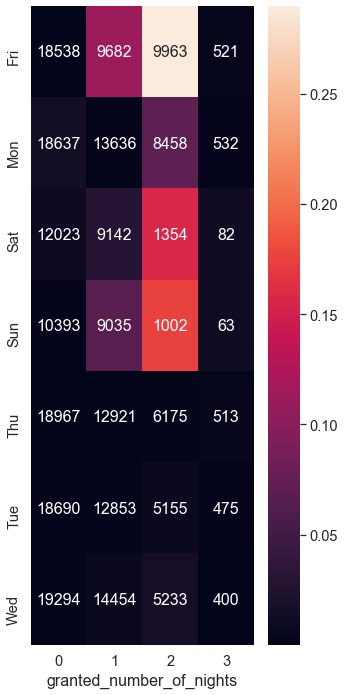

In [523]:
plot_cont(X="request_creation_day", Y="granted_number_of_nights", 
          data=requests_train)

=> OK : day of week as feature

In [524]:
requests_train["request_creation_month"].value_counts(dropna=False)

01    82368
03    81168
02    74655
Name: request_creation_month, dtype: int64

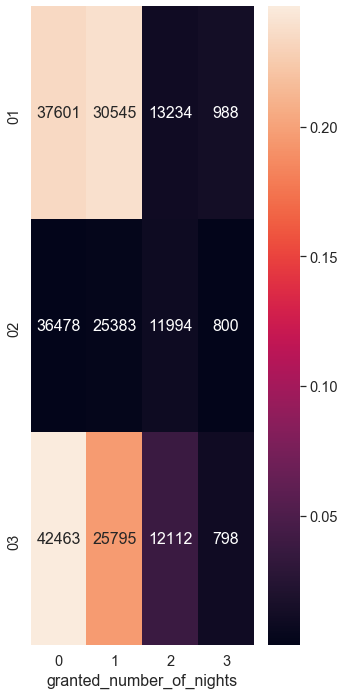

In [525]:
plot_cont(X="request_creation_month", Y="granted_number_of_nights", 
          data=requests_train)

=> OK : month as feature

Use the delay between request creation and answer ?

In [526]:
requests_train[requests_train["answer_creation_date"] < '2019-01-01 00:00:00']

request_id animal_presence answer_creation_date  \
11470   df81003c2637d74eb2a86d2ef5e7a5eb               f  2018-12-31 23:00:00   
31961   f5151019b9d9799fee381acf92ae884e               f  2012-02-18 23:00:00   
169308  6a8823886c5f1105ca5c4981e6076d24               f  2018-12-31 23:00:00   
195935  db37dfaaa9c550ba56edd8cd9cf534b9               f  2018-12-31 23:00:00   
197753  0e39e437fcd10db068dfdf3f2e9297a4               f  2018-12-23 23:00:00   
219596  565dda0d8c7b5addcae209b11f124eb5               f  2018-01-08 23:00:00   
230481  cf48d4fb1c8ea65608ee9c7b7debe985               f  2018-12-30 23:00:00   

        child_situation child_to_come  district  granted_number_of_nights  \
11470                -1       unknown        93                         3   
31961                -1       unknown    314550                         0   
169308               30             f        36                         3   
195935               10             f        36                         2   
197753               -1       unknown        69                         3   
219596               -1             f        39                         0   
230481               -1       unknown        81                         0   

        group_composition_id        group_composition_label  \
11470                     40  single mother with child(ren)   
31961                     10                      man alone   
169308                    20                    woman alone   
195935                    40  single mother with child(ren)   
197753                    10                      man alone   
219596                    20                    woman alone   
230481                    10                      man alone   

            group_creation_date  ... age_min age_mean  \
11470   2018-09-27 14:02:12.739  ...     2.0     17.5   
31961   2019-02-19 16:21:28.881  ...    29.0     29.0   
169308  2018-08-22 06:57:34.159  ...    52.0     52.0   
195935  2018-09-27 18:12:22.447  ...    12.0     28.0   
197753  2019-01-02 09:51:16.924  ...    23.0     23.0   
219596  2019-01-09 15:59:29.162  ...    26.0     26.0   
230481  2018-12-08 08:29:00.345  ...    35.0     35.0   

       disabled_worker_certification  nb_female nb_male married  \
11470                              f        1.0     1.0       f   
31961                              f        0.0     1.0       f   
169308                             f        1.0     0.0       f   
195935                             f        2.0     0.0       f   
197753                             f        0.0     1.0       f   
219596                             f        1.0     0.0       f   
230481                             f        0.0     1.0       f   

        request_creation_date_fmt request_creation_day  \
11470         2019-02-01 10:17:33                  Fri   
31961         2019-02-19 16:21:18                  Tue   
169308        2019-01-02 12:32:20                  Wed   
195935        2019-01-02 09:39:26                  Wed   
197753        2019-01-02 09:51:38                  Wed   
219596        2019-01-10 08:50:22                  Thu   
230481        2019-01-01 01:56:55                  Tue   

       request_creation_day_num request_creation_month  
11470                         5                     02  
31961                         2                     02  
169308                        3                     01  
195935                        3                     01  
197753                        3                     01  
219596                        4                     01  
230481                        2                     01  

[7 rows x 40 columns]

=> NOK : some date are not possible (answer before request...)

We put 0 for these delay

In [527]:
ser_delay = (requests_train["answer_creation_date"].astype("datetime64") - \
    requests_train["request_creation_date_fmt"])
ser_delay = ser_delay.dt.days
#ser_delay[ser_delay.values < 0] = 0
ser_delay

0         0
1         0
2         0
3         0
4         0
         ..
238186    0
238187    0
238188    0
238189    0
238190    0
Length: 238191, dtype: int64

In [528]:
ser_delay.astype(int).loc[ser_delay.values < 0] = 0

In [529]:
ser_delay.value_counts()

 0       238040
-2           63
-1           19
 2           10
-3           10
 1            7
 5            5
 6            4
 11           3
 25           2
 7            2
 8            2
 9            2
 27           2
 16           1
 3            1
-2558         1
 4            1
 10           1
-4            1
-367          1
-5            1
-59           1
-53           1
-40           1
-32           1
-20           1
-16           1
-15           1
-13           1
-10           1
-7            1
-6            1
 26           1
dtype: int64

=> Delay NOK : Too few values > 0 

### child_situation

In [530]:
requests_train["child_situation"].value_counts()

-1     228080
 10      8108
 30       835
 20       543
 70       241
 40       230
 50        99
 60        55
Name: child_situation, dtype: int64

In [531]:
bol_10 = requests_train["child_situation"] == 10
requests_train[bol_10]["group_composition_label"].value_counts()

single mother with child(ren)    3786
couple with child(ren)           3424
group with child(ren)             460
single father with child(ren)     173
woman alone                       105
man alone                          50
group of adults                    48
child/underage with family         31
couple without whildren            19
isolated child/underage             9
accompanied child/underage          3
Name: group_composition_label, dtype: int64

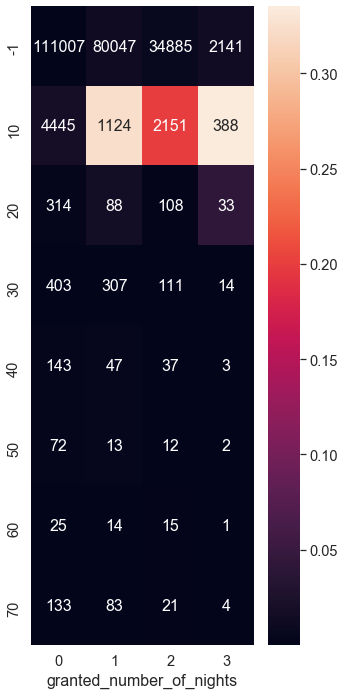

In [532]:
plot_cont(X="child_situation", Y="granted_number_of_nights", 
          data=requests_train)

We can reduce to child_situation == 10 : 

In [533]:
requests_train["child_situation_red"] = requests_train["child_situation"]
requests_train.loc[bol_10, "child_situation_red"] = 1
requests_train.loc[~bol_10, "child_situation_red"] = 0

Same for Test :

In [535]:
bol_10 = requests_test["child_situation"] == 10
requests_test["child_situation_red"] = requests_test["child_situation"]
requests_test.loc[bol_10, "child_situation_red"] = 1
requests_test.loc[~bol_10, "child_situation_red"] = 0

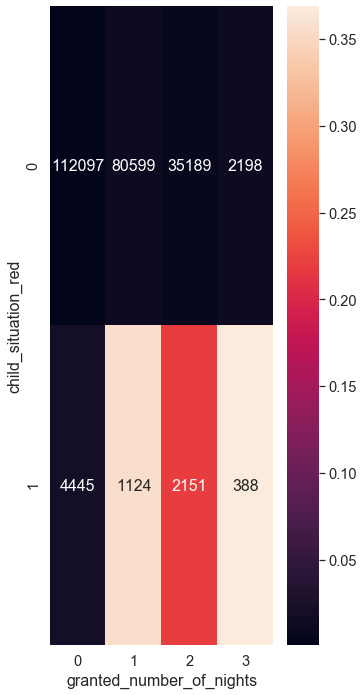

In [534]:
plot_cont(X="child_situation_red", Y="granted_number_of_nights", 
          data=requests_train)

=> OK for "child_situation_red" as feature

## Save 

In [567]:
requests_train.to_csv(path_or_buf=PATH_REQ_TRAIN_CLEAN, index=False)

In [568]:
requests_test.to_csv(path_or_buf=PATH_REQ_TEST_CLEAN, index=False)

In [539]:
individuals_train.to_csv(path_or_buf=PATH_IND_TRAIN_CLEAN, index=False)

In [540]:
individuals_test.to_csv(path_or_buf=PATH_IND_TEST_CLEAN, index=False)